# E-commerce — Выявление профилей потребления

**Материалы:**

[Презентация](https://disk.yandex.ru/i/0rCdFctvFVsfmw)

***Изучение общей информации***


цель и задача проекта
источники данных
загрузка библиотек

***1.Предобработка данных***

проверка типа данных - info
наличие пропусков
наличие дубликатов
количество уникальных значений столбцов
смена названий столбцов к нижнему регистру
удаление пропусков и дубликатов, если они влияют на результат исследования
замена типа данных

***2.Исследовательский анализ данных***

создание столбца с выручкой
создание столбца с месяцем
среднее количество покупок на покупателя
средний чек на покупателя
гистограмма по дате и количеству покупок
гистограмма по дате и среднему чеку
выявление аномальных значений по количеству покупок, стоимости, среднему чеку

***3.Сегментация покупателей на основе истории их покупок***

разбивка на категории по группам товаров
распределение среднего чека по сегментам
распределение частоты покупок по сегментам

***4.Проверка статистических гипотез***

различие/нет выручки между кластерами
различие/нет среднего между кластерами

***5.Выводы и рекомендации***

# Содержание

1. [Предобработка данных](#start)
2. [Исследовательский анализ данных](#analys) 
3. [Сегментация покупателей на основе истории их покупок](#segment) 
4. [Проверка статистических гипотез](#stat)
5. [Выводы и рекомендации](#conclusion) 

***Цель иссследования:***

В рамках проекта проводится исследование истории покупок клиентов интернет-магазина товаров для дома и быта «Пока все ещё тут». Целью исследования является выявление профилей потребления для состевления подробных рекомендаций заказчику по кластерам пользователей с целью улучшения рекламных рассылок, увеличения количества продаваемого товара, возвращаемости клиентов и т.д.

***Изучение общей информации***

*Описание данных:*
Колонки в ecommerce_dataset.csv :

date — дата заказа;
customer_id — идентификатор покупателя;
order_id — идентификатор заказа;
product — наименование товара;
quantity — количество товара в заказе;
price — цена товара.

In [1]:
#импорт библиотек
import pandas as pd
import datetime as dt
from datetime import datetime

from pymystem3 import Mystem
from collections import Counter 

import numpy as np

import itertools

import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from plotly import graph_objects as go


import warnings
                         

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

import warnings                                             
warnings.filterwarnings('ignore')   

In [2]:
google_id = "1DkqEQWZoHh22YrsYcNUxSzlhgFqdl0tf"
df = pd.read_csv(f"https://drive.google.com/uc?export=download&id={google_id}" )
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


***1.Предобработка данных***<a id="start"></a>

In [4]:
#проверка на пропуски
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

In [5]:
#проверка на дубликаты
df.duplicated().sum()

0

In [6]:
#для более корректной проверки, проверим дубликаты без столбца date
df[df[['customer_id', 'order_id', 'product']].duplicated() == True].sort_values(by=['order_id', 'price']).head()

,date,customer_id,order_id,product,quantity,price
378,2018102313,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
511,2018102819,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
590,2018110214,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
760,2018111017,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0
818,2018111515,b80e4826-7218-4bf9-ac08-eb2c81ab3f62,13547,Рассада зелени для кухни Тимьяна в кассете по ...,1,162.0


In [7]:
df[['customer_id', 'order_id', 'product']].duplicated().sum()

1886

дубликатов без столбца времени 1894, удалим их так как они могут исказить результаты, а оставшихся данных достаточно для исследования

In [8]:
df = (df[df[['customer_id', 'order_id', 'product']].duplicated(keep='last') != True])
df.shape

(5588, 6)

In [9]:
#проверка неявных дубликатов
df['product'] = df['product'].str.lower()

In [10]:
df.nunique()

date           2756
customer_id    2451
order_id       3521
product        2341
quantity         49
price           407
dtype: int64

In [11]:
#меняем тип данных у столбца с датой на формат времени
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5588 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5588 non-null   datetime64[ns]
 1   customer_id  5588 non-null   object        
 2   order_id     5588 non-null   int64         
 3   product      5588 non-null   object        
 4   quantity     5588 non-null   int64         
 5   price        5588 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 305.6+ KB


In [13]:
df['date'].describe()

count                    5588
unique                   2756
top       2019-04-27 16:00:00
freq                       51
first     2018-10-01 00:00:00
last      2020-01-31 15:00:00
Name: date, dtype: object

**Проверка на наличие заказов совершенных более чем одним покупателем**

In [14]:
len(df['order_id'].unique())

3521

Было осуществлено 2 784 заказа. В один заказ могли попасть разные товары. Кроме того, один пользователь мог сделать несколько заказов

In [15]:
unique_customer = df.groupby(['order_id']).agg({'customer_id': ['nunique']})['customer_id']
unique_customer['nunique'].value_counts()

1    3492
2      26
3       2
4       1
Name: nunique, dtype: int64

есть несколько заказов, которые дублируются

In [16]:
(df.groupby(['order_id']
             ).agg({'customer_id': ['nunique']})['customer_id']
).sort_values(by='nunique').tail(1)

,nunique
order_id,
72845,4


In [17]:
df[df['order_id'] == 72845]

,date,customer_id,order_id,product,quantity,price
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,муляж яблоко зеленый 9 см полиуретан,40,59.0


<div class="alert alert-block alert-info">Возможно заказ перезаписывался несколько раз и по факту это можно считать одним заказом и оставим только последнюю строку - самую позднюю запись о заказе</div>

In [18]:
#удалим заказы, где на один заказ приходится больше одного клиента
df = df.drop_duplicates(subset=['order_id', 'product'], keep='last')

Минимальная дата - 1 октября 2018 г. Максимальная - 31 октября 2020 г

**Вывод:**  провели предобработку данных, проверили на пропуски и дубликаты, убрали их, привели стобцы к нужным для исследования типам данных

***2.Исследовательский анализ данных***<a id="analys"></a>

In [19]:
#столбец с выручкой, чтобы посчитать стоимость заказа
df['revenue'] = df.quantity * df.price

In [20]:
#столбец с месяцем, для удобства отображения изменений во времени
df['month'] = df['date'].astype('datetime64[M]')

In [21]:
df.describe()

,order_id,quantity,price,revenue
count,5554.000000,5554.000000,5554.000000,5554.000000
mean,55982.743068,2.586244,531.639194,830.953262
std,32440.287139,16.470806,974.301212,9198.016525
min,12624.000000,1.000000,9.000000,9.000000
25%,14810.250000,1.000000,90.000000,120.000000
50%,69205.500000,1.000000,150.000000,191.000000
75%,71936.750000,1.000000,524.000000,734.000000
max,112789.000000,1000.000000,14917.000000,675000.000000


**Количество единиц товаров в одной покупке**

In [22]:
df.groupby('order_id').agg({'quantity': 'sum'}).describe()

,quantity
count,3521.000000
mean,4.079523
std,21.280751
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1000.000000


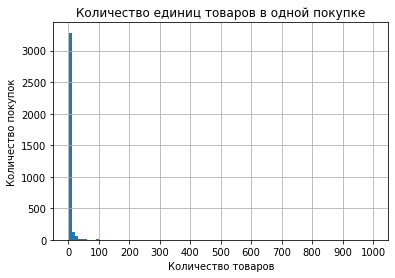

In [23]:
df.groupby('order_id').agg({'quantity': 'sum'}).hist(bins=100)

plt.title('Количество единиц товаров в одной покупке')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупок');

логично, что подавляющее большинство покупок совершается с малым количеством единиц товаров в одной покупке, рассмотрим подробнее

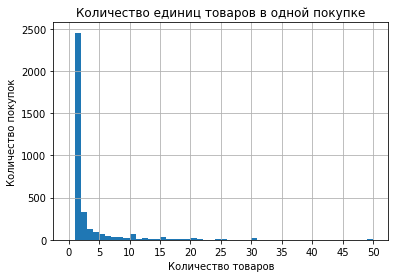

In [24]:
#рассмотрим заказы до 50 товаров в покупке
df.groupby('order_id').agg({'quantity': 'sum'}).hist(range=(0, 50), bins=50)

plt.title('Количество единиц товаров в одной покупке')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупок');

изучим "хвост" с большим числом товаров в одном заказе 

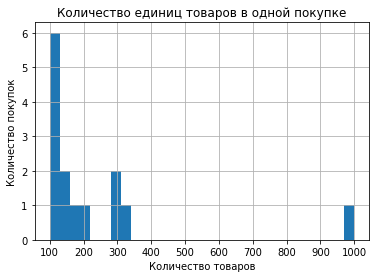

In [25]:
df.groupby('order_id').agg({'quantity': 'sum'}).hist(range=(100, 1000), bins=30)

plt.title('Количество единиц товаров в одной покупке')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупок');

как видно, покупки совершались и с таким большим количеством единиц товаров в одном заказе, также виден выброс в виде покупке с 1000 единиц в одном заказе

Теперь рассмотрим относительно покупателя

**Количество единиц всех товаров на одного покупателя**

In [26]:
df.groupby('customer_id').agg({'quantity': 'sum'}).describe()

,quantity
count,2430.000000
mean,5.911111
std,27.057833
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,1000.000000


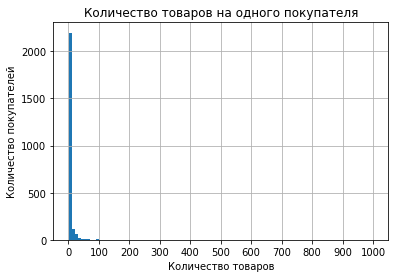

In [27]:
df.groupby('customer_id').agg({'quantity': 'sum'}).hist(bins=100)

plt.title('Количество товаров на одного покупателя')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупателей');

По гистограмме видно, наибольшее количество покупателей совершают покупки с малым количеством товара

По аналогии с количеством товаров на один заказ, рассмотрим более детально количество товаров на одного покупателя

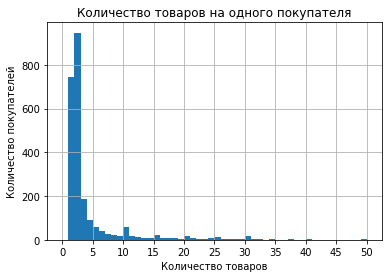

In [28]:
df.groupby('customer_id').agg({'quantity': 'sum'}).hist(range=(0, 50), bins=50)

plt.title('Количество товаров на одного покупателя')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупателей');

В основном берут 1-3 товара, более 10  -крайне редко

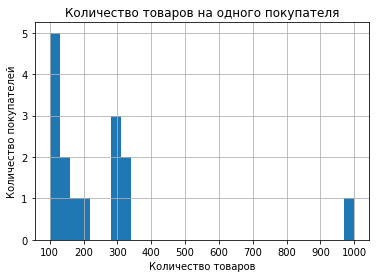

In [29]:
df.groupby('customer_id').agg({'quantity': 'sum'}).hist(range=(100, 1000), bins=30)

plt.title('Количество товаров на одного покупателя')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Количество товаров')
plt.ylabel('Количество покупателей');

есть выброс 1000 товаров на одного покупателя, 5 человек совершили покупки на 100 товаров

Теперь рассмотрим сами товары, а именно их наименования

**Количество наименований товаров на одного покупателя**

In [30]:
df.groupby('customer_id').agg({'product': 'count'}).describe()

,product
count,2430.000000
mean,2.285597
std,4.372892
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,143.000000


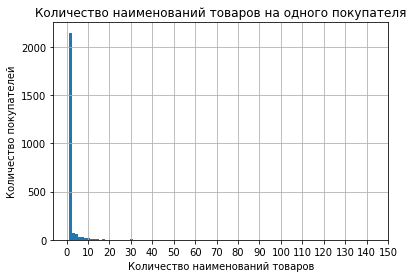

In [31]:
df.groupby('customer_id').agg({'product': 'count'}).hist(bins=100)

plt.title('Количество наименований товаров на одного покупателя')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество наименований товаров')
plt.ylabel('Количество покупателей');

По гистограмме видно, что количество наименований на одного показателя в основном в диапазоне от 0 до 20, рассмотрим более подробно этот диапазион

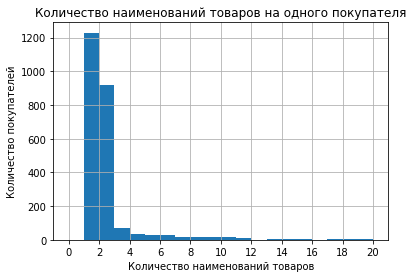

In [32]:
df.groupby('customer_id').agg({'product': 'count'}).hist(range=(0, 20), bins=20)

plt.title('Количество наименований товаров на одного покупателя')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('Количество наименований товаров')
plt.ylabel('Количество покупателей');

С большим отрывом лидирует 1-2 наименования товаров на одного поккупателя, 3 и более наименования приобретали сильно меньше раз

**Распределение количества покупок по месяцам**

In [33]:
df.groupby(['month']).agg({'order_id': 'nunique'})

,order_id
month,
2018-10-01,238
2018-11-01,204
2018-12-01,280
2019-01-01,168
2019-02-01,288
2019-03-01,248
2019-04-01,265
2019-05-01,180
2019-06-01,164


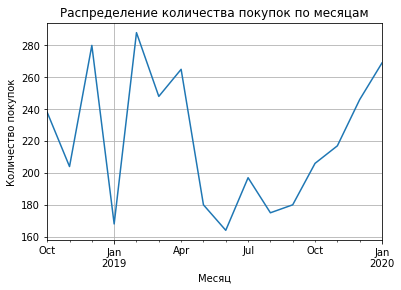

In [34]:
df.groupby(['month']).agg({'order_id': 'nunique'}) \
      .plot(grid=True, legend=False)
plt.title('Распределение количества покупок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество покупок');

1. Спад отмечался 2 раза - январь 2019, июнь 2019; 
2. Наибольшее количество покупок совершали в декабре 2018, февраль 2019, также стоит отметить рост в конце 2019 года (возможно была преодолена сезонность и совершена удачная рекламная кампания)

**Точечный график количества покупок по пользователям**

,customer_id,orders
1900,c971fb21-d54c-4134-938f-16b62ee86d3b,126
736,4d93d3f6-8b24-403b-a74b-f5173e40d7db,35
1089,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,17
1732,b7b865ab-0735-407f-8d0c-31f74d2806cc,7
17,0184f535-b60a-4914-a982-231e3f615206,5
694,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,4
1804,bea7a833-2074-42db-bc49-4457abd3c930,4
2127,e0535076-6270-4df2-8621-cb06264a94fa,4
994,6a86cc77-ef15-496f-b5d3-89005597ee5d,3
2214,eb6521ae-56e3-4a72-9ea2-e9c69701ff3f,3


Text(0, 0.5, 'Количество покупок')

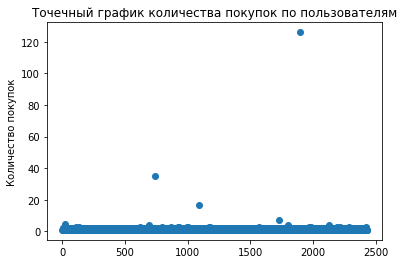

In [35]:
orders_by_users = (
    df.groupby('customer_id', as_index=False)
    .agg({'order_id': 'nunique'})
)
orders_by_users.columns = ['customer_id', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(10))

x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(x_values, orders_by_users['orders']);

plt.title('Точечный график количества покупок по пользователям')
plt.ylabel('Количество покупок')

95-й и 99-й перцентили количества покупок по пользователям

In [36]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 3.]


5% пользователей больше 2х заказов, 1% больше трех заказов

**Выручка с одной покупки**

In [37]:
df.groupby('order_id').agg({'revenue': 'sum'}).describe()

,revenue
count,3521.000000
mean,1310.739681
std,11545.556533
min,9.000000
25%,194.000000
50%,577.000000
75%,1247.000000
max,675000.000000


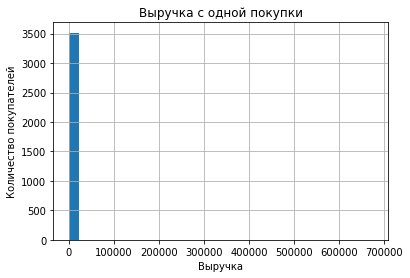

In [38]:
df.groupby('order_id').agg({'revenue': 'sum'}).hist(bins=30)

plt.title('Выручка с одной покупки')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Выручка')
plt.ylabel('Количество покупателей');

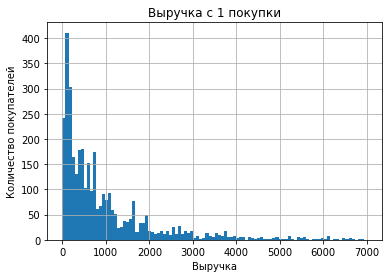

In [39]:
df.groupby('order_id').agg({'revenue': 'sum'}).hist(range=(0, 7000), bins=100)

plt.title('Выручка с 1 покупки')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Выручка')
plt.ylabel('Количество покупателей');

In [40]:
revenue_orders = (
    df.groupby('order_id', as_index=False)
    .agg({'revenue': 'sum'})
)

print(np.percentile(revenue_orders['revenue'], [95, 99])) 

[3776.  7576.8]


5% пользователей принесли выручку не менее 4553,5, 1%  -  не менее 8693,01

**Выручка на одного покупателя**

In [41]:
df.groupby('customer_id').agg({'revenue': 'sum'}).describe()

,revenue
count,2430.00000
mean,1899.22404
std,14328.88266
min,15.00000
25%,396.25000
50%,838.00000
75%,1798.00000
max,675000.00000


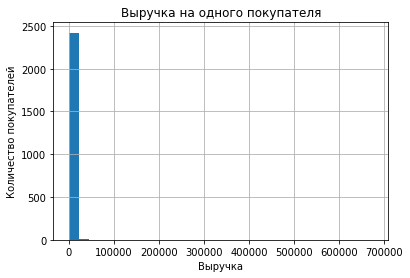

In [42]:
df.groupby('customer_id').agg({'revenue': 'sum'}).hist(bins=30)

plt.title('Выручка на одного покупателя')
plt.xlabel('Выручка')
plt.ylabel('Количество покупателей');

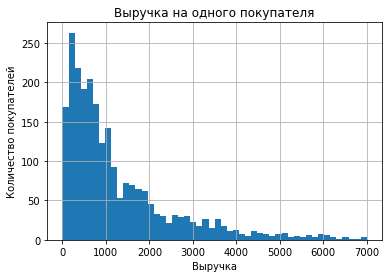

In [43]:
df.groupby('customer_id').agg({'revenue': 'sum'}).hist(range=(0, 7000), bins=50)

plt.title('Выручка на одного покупателя')
plt.locator_params(axis='x', nbins=10)
plt.xlabel('Выручка')
plt.ylabel('Количество покупателей');

95-й и 99-й перцентили выручки на одного покупателя

In [44]:
revenue_buyers = (
    df.groupby('customer_id', as_index=False)
    .agg({'revenue': 'sum'})
)

print(np.percentile(revenue_buyers['revenue'], [95, 99]))

[ 4888.3  10094.63]


5% пользователей принесли выручку не менее 4727.5,  1% пользователей - не менее 9698,5

**Изменение общей выручки по месяцам**

In [45]:
df.groupby(['month']).agg({'revenue': 'sum'})

,revenue
month,
2018-10-01,350748.000000
2018-11-01,359772.000000
2018-12-01,345475.000000
2019-01-01,234715.000000
2019-02-01,306059.000000
2019-03-01,255704.000000
2019-04-01,316691.000000
2019-05-01,230806.000000
2019-06-01,910319.000000


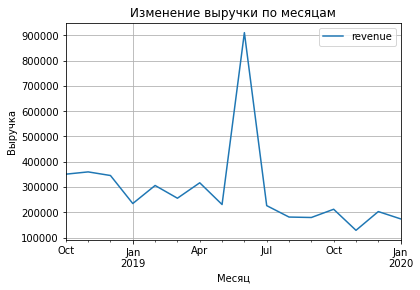

In [46]:
df.groupby(['month']).agg({'revenue': 'sum'}) \
      .plot(grid=True)
plt.title('Изменение выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка');

Имеется аномальный рост выручки в июне 2019 года, 2019-06-01   - 	911718.0

**Изменение среднего чека покупателя по месяцам**

In [47]:
average_check = df.groupby(['month']).agg({'revenue':'sum','customer_id':'nunique'}).reset_index()
average_check['average_check'] = average_check['revenue'] / average_check['customer_id']
average_check

,month,revenue,customer_id,average_check
0,2018-10-01,350748.000000,179,1959.486034
1,2018-11-01,359772.000000,178,2021.191011
2,2018-12-01,345475.000000,231,1495.562771
3,2019-01-01,234715.000000,152,1544.177632
4,2019-02-01,306059.000000,246,1244.142276
5,2019-03-01,255704.000000,233,1097.442060
6,2019-04-01,316691.000000,236,1341.911017
7,2019-05-01,230806.000000,166,1390.397590
8,2019-06-01,910319.000000,154,5911.162338
9,2019-07-01,226361.000000,185,1223.572973


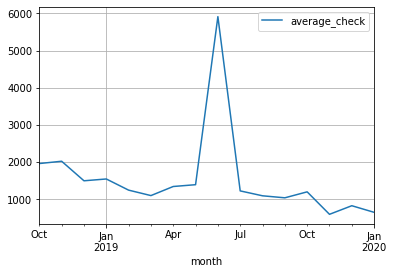

In [48]:
average_check.plot(x='month', y='average_check', grid=True);

Средний чек был аномально велик в июне 2019 года и составил   5770.367089

**Аномалии**

*5 самых дорогих товаров*

In [49]:
df.sort_values(by='price', ascending=False).head()

,date,customer_id,order_id,product,quantity,price,revenue,month
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,сушилка уличная leifheit 85210 linomatic v 400...,1,14917.0,14917.0,2019-07-01
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,сумка-тележка хозяйственная andersen royal sho...,1,8737.0,8737.0,2019-04-01
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,сумка-тележка хозяйственная andersen alu star ...,1,8437.0,8437.0,2019-02-01
7436,2020-01-26 19:00:00,04416514-5346-4f90-93e3-fb7365e2ee8c,109758,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0,8077.0,2020-01-01
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,сумка-тележка хозяйственная rolser mnb019 rojo...,1,8077.0,8077.0,2019-04-01


*5 покупателей, сделавших самую большую выручку*

In [50]:
df.groupby('customer_id').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head()

,revenue
customer_id,
312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,675000.0
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0
4d93d3f6-8b24-403b-a74b-f5173e40d7db,57278.0
58a4c3cc-504f-43ea-a74a-bae19e665552,53232.0
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0


*рассмотрим детально аномалию с заказом 675000*

In [51]:
df.query('customer_id == "312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6"')

,date,customer_id,order_id,product,quantity,price,revenue,month
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"вантуз с деревянной ручкой d14 см красный, bur...",1000,675.0,675000.0,2019-06-01


1000 вантузов - это мощно :)

<div class="alert alert-block alert-info">так как  1000 вантузов явный выброс, или даже ошибка, лучше удалить</div>

In [52]:
df=df.drop(index=5456)

In [53]:
df.groupby('customer_id').agg({'revenue': 'sum'}).sort_values(by='revenue', ascending=False).head()

,revenue
customer_id,
c971fb21-d54c-4134-938f-16b62ee86d3b,159508.0
4d93d3f6-8b24-403b-a74b-f5173e40d7db,57278.0
58a4c3cc-504f-43ea-a74a-bae19e665552,53232.0
146cd9bf-a95c-4afb-915b-5f6684b17444,49432.0
498f12a4-6a62-4725-8516-cf5dc9ab8a3a,41900.0


**Выводы:**

1. подавляющее большинство покупок совершается с малым количеством единиц товаров в одной покупке;
2. выявлен выброс в виде покупке с 1000 единиц в одном заказе;
3. наибольшее количество покупателей совершают покупки с малым количеством товара;
4. в основном берут 1-3 товара, более 10 -крайне редко;
5. есть выброс 1000 товаров на одного покупателя, 5 человек совершили покупки на 100 товаров;
6. количество наименований на одного показателя в основном в диапазоне от 0 до 20;
7. с большим отрывом лидирует 1-2 наименования товаров на одного поккупателя, 3 и более наименования приобретали сильно меньшее количество раз;
8. наибольшее количество покупок совершали в декабре 2018, февраль 2019, также стоит отметить рост в конце 2019 года, спад отмечался 2 раза - январь 2019, июнь 2019;
9. 5% пользователей совершали больше 2х заказов, 1% больше трех заказов;
10. 5% пользователей принесли выручку не менее 4727.5, 1% - не менее 9698,5;
11. также изучили аномалии (в частности посмотрели на самую дорогую покупку)

In [54]:
dashboard = df.to_csv('dash.csv')

***3.Сегментация покупателей на основе истории их покупок***<a id="segment"></a>

***Разбивка на категории по группам товаров***

*сформируем список уникальных товаров*

In [55]:
product_unique = df['product'].unique()
product_unique

array(['комнатное растение в горшке алое вера, d12, h30',
       'комнатное растение в горшке кофе арабика, d12, h25',
       'радермахера d-12 см h-20 см', ...,
       'сушилка для белья на ванну freudenberg (gimi) alablock varadero silver a4p',
       'каланхое каландива малиновое d-7 см', 'литопс микс d-5 см'],
      dtype=object)

*Лемматизация по списку уникальных товаров*

для лемматизации воспользуемся библиотекой на русском языке — 'pymystem3', так как 'pymystem3' по умолчанию выдает только список лемматизированных слов, итоговый результат склеим методом join()

в списке фигурируют схожие слова, при этом они определяются как разные товары. Для выделения наиболее популярных направлений воспользуемся контейнером Counter

In [56]:
m = Mystem()
string = '; '.join(product_unique)
lemmas = m.lemmatize(string)
goods = Counter(lemmas).most_common()

*Выполним сортировку списка встречающихся слов и символов по убыванию частоты*

In [57]:
for i in range(0,len(goods)): 
    print(goods[i]) 

(' ', 15366)
('; ', 2335)
(', ', 1064)
('см', 1060)
('-', 976)
('для', 547)
(',', 295)
('в', 274)
('d', 260)
('л', 253)
('с', 253)
('рассада', 221)
('5', 190)
(' (', 173)
('белый', 172)
('сорт', 171)
('кассета', 170)
('шт', 169)
('0', 164)
('12', 147)
('белье', 144)
('красный', 143)
(') ', 140)
('доска', 132)
('/', 132)
('горшок', 130)
('9', 123)
('сушилка', 120)
('цветок', 118)
('объем', 114)
('гладильный', 113)
('2', 113)
('6', 110)
('тележка', 108)
('1', 108)
('по', 101)
('4', 101)
('томат', 100)
('10', 99)
('сумка', 98)
('. ', 98)
('диам', 95)
('помидор', 93)
('*', 90)
('№', 88)
('пеларгония', 86)
('розовый', 84)
('из', 82)
('3', 82)
('и', 81)
('luminarc', 79)
('хозяйственный', 77)
('gimi', 75)
('7', 75)
('ника', 75)
('среднеспелый', 73)
('20', 72)
('коврик', 72)
('ванный', 72)
('кухня', 71)
('зелень', 68)
('муляж', 68)
('роза', 68)
('черный', 67)
('мл', 67)
('синий', 63)
('махровый', 62)
('м', 61)
('г', 61)
('зональный', 61)
('искусственный', 61)
('h', 60)
('чехол', 60)
('attribut

*Разбиваем товары по категориям, создаем словарь*

In [58]:
dictionary_category = {  
   'Товары для кухни': ['кухня', 'крышка', 'тарелка', 'скатерть', 'пищевой', 'салатник', 'чайник', 'банка', 'салфетка',
                       'десертный', 'обеденный', 'ложка', 'кухонный', 'сковорода', 'противоскользящий', 'мытье', 'посуда',
                       'столовый', 'мыло', 'керамический', 'антипригарный', 'суповой', 'чайный', 'стакан', 'лососевый',
                       'кофе', 'столовая', 'кружка', 'кастрюля','арабика', 'вилка', 'фужер', 'вино', 'выпечка', 'свч', 'термос',
                       'чили', 'чай', 'разделочный',
                       'антижир', 'банка', 'бидон', 'блюдо', 'блюдце', 'бокал', 'бульонница', 'бутылка', 'бутылочный', 'венчик',
                       'вилка', 'выпечка', 'герметичный', 'губка', 'измельчитель', 'картофелемялка', 'кастрюля', 'кекс',
                       'кипятильник', 'кондитерский', 'кружка', 'крышка', 'кухонный', 'лопатка', 'ложка', 'мантоварка',
                       'мантоварка-пароварка', 'миксер', 'мини-сковорода', 'миска', 'мука', 'нож', 'ножеточка', 'овощеварка',
                       'овощечистка', 'овсянница', 'орехоколка', 'отделитель', 'плита', 'половник', 'посуда', 'посудомоечный',
                       'пресс', 'продукт', 'противень', 'разделочный', 'рыбочистка', 'салатник', 'салфетница', 'сахарница', 'свч',
                       'сито', 'скалка', 'скатерть', 'сковорода', 'соковарка', 'соковыжималка', 'сотейник', 'стакан', 'столовый',
                       'тарелка', 'терка', 'термокружок', 'термос', 'термостакан', 'толкушка', 'тортница', 'фужер', 'хлебница',
                       'чайник', 'чайный', 'электроштопор', 'яйцо',
                       'кухн', 'тарелка', 'нож', 'салатник', 'чайник', 'банка', 'салфетка', 'рыбочистка',
                       'термостакан', 'котел', 'салфетница', 'рассекатель', 'дуршлаг', 'бульонница', 'скалка', 'тортница', 
                       'сотейник', 'отделитель', 'сахарница', 'половник', 'бидон','блюдо','блюдце','вилка','разделочная',
                       'емкость','жестяная','измельчитель', 'картофелемялка','кастрюля','кипятильник','кисточка','хлебница','интерьерный',
                       'кружка', 'крышка', 'кувшин', 'кухонное','кухонные','столов','чайная','холодца','мантоварка',
                       'пароварка','масленка','мерный','стакан','миксер','мини-сковорода','мирт','миска','модульная', 
                       'бокалов','для пикника', 'фужер', 'ножеточка','овощеварка','овощечистка', 'просеиватель','противень',
                       'сковорода',
                       'скребок','соковарка','соковыжималка', 'стеклянная','тepмокружка', 'терка', 'термокружка','толкушка',
                       'фал капроновый','форма','ложка','электроштопор','сито', 'подставка для яйца', 'орехоколка',
                       'кухонных полотенец', 'чайный', 'кексов', 'пресс для чеснока', 'кофе арабика', 'кружек для пива', 'термос',
                       'венчик', 'набор посуды'],
        
    'Товары для домашней утвари': ['белье', 'доска', 'горшок', 'сушилка', 'сумка', 'коврик', 'ванный', 'махровый',
                                  'штора', 'вешалка', 'хлопок', 'придверный', 'таз', 'комнатный', 'корзина', 'домашний',
                                  'полумахровый', 'упаковка', 'ванна', 'текстильный', 'крючок', 'швабра', 'полотенце', 'полка',
                                  'ерш', 'хлопковый', 'ковер', 'косметь', 'обувь', 'патиссон', 'хозлэнд', 'лоток', 'отжим',
                                  'флисовый', 'простыня', 'весы', 'текстиль', 'унитазный', 'прищепок', 'плед', 'пыль', 'ворсовый',
                                  'покрывало', 'наволочка', 'одеяло', 'ткань',
                                  'd-', 'd-5', 'd-7', 'd-9', 'D10', 'd-10', 'd-11', 'D12', 'D12,', 'd12', 'd-12', 'd-13', 'd-14', 'd-15',
                                  'd-17', 'd-18', 'd-19', 'd-20', 'd-21', 'D23', 'd-23', 'бак', 'ванна', 'ванная', 'ванный', 'вантуз', 'ваза',
                                  'ведро', 'весы', 'вешалка', 'вешалка-перекладина', 'вешалка-плечики', 'вешалка-стойка', 'вешалка-сушилка',
                  'вещь', 'гладильный', 'глажение', 'засор', 'зубной', 'известковый', 'искусственный', 'искуственный', 'калла',
                  'ключница', 'ковер', 'коврик', 'ковш', 'комнатный', 'кондиционер', 'корзина', 'коробка', 'кофр', 'крючок',
                  'лавр', 'лоток', 'мыло', 'мыло-скраб', 'муляж', 'наволочка', 'наматрацник', 'наматрицник-чехол',
                  'наматрасник', 'насадка', 'насадка-моп', 'одеяло', 'окномойка', 'отбеливатель', 'перчатка', 'плед', 'плечики',
                  'подголовник', 'пододеяльник', 'подрукавник', 'подушка', 'покрывало', 'пол', 'полимербыт', 'полировка',
                  'полотенце', 'постельный', 'прищепок', 'простыня', 'пыль', 'пятно', 'радиаторный', 'ролик', 'салфетка',
                  'сантехника', 'светильник', 'скребок', 'совок', 'стиральный', 'стирка', 'сушилка', 'таз', 'ткань', 'тряпка',
                  'тряпкодержатель', 'туалет', 'туалетный', 'увлажнять', 'унитаз', 'унитазный', 'утюг', 'фен', 'фоторамка',
                  'халат', 'хранение', 'цикламен,', 'чехол', 'швабра', 'щетка', 'щетка-утюжок', 'шило', 'штора'
                                  'доска', 'гладильн', 'ванн', 'влаговпитывающий', 'туалета', 'таз', 'щетка', 
                  'ведр', 'насадка', 'ополаскиватель', 'антинакипин', 'ароматизирован', 'прищепки','веник','гель',
                  'прищепок','губка','защитная','соль','кондиционер','контейнер','стирки', 'мытья','швабре', 'настенная', 'пена',
                  'перчатки','швабр','совок','глажен','налет','антижир','пылесос','крем', 'сушилк','подрукавник','совком', 
                  'для чистки','мыть', 'средство', 'мойк', 'утюг', 'покрытие', 'тряпка','корзина', 'корыто',  
                  'вантуз', 'сменный','дозатор', 'сметка', 'скребок', 'окномойка', 'чистящий','чистки', 'ерш','отбеливатель',
                  'стиральный', 'держатель', 'запасная', 'коврик', 'ковш', 'мыльница', 'подголовник', 'пробка','унитаза', 
                  'зубная','мыло','жидкое','мыло-скраб','увлажняющая', 'маска', 'фен дорожный', 'тряпкодержатель', 'полотенце',
                  'махровых салфеток', 'нетканые салфетки', 'полотенец', 'ткань универсальная', 'ёрш'
                  'муляж', 'искусственный', 'штора', 'штор', 'скатерть', 'подушка','покрывало',
                  'белье', 'искусственная', 'декоративная', 'новогоднее', 'подарочный', 'ваза','фоторамка',
                  'комнатное растение', 'двуспальное','постельное', 'ковер', 'кольца', 'махровое','халат', 'ковров', 
                  'наволочка', 'наматрасник', 'одеяло', 'плед', 'подкладка', 'чехол','простыня', 'простынь', 'наматрацник',
                  'пододеяльник',
                  'придверный', 'вешалка', 'вешалок', 'одежда', 'крючок', 'фиксатор-шар', 'ключница', 'вакуумный',
                  'весы', 'вешалки','вкладыши','короб','коробка','кофр', 'обувная','лоток','мусора',
                 'монетчатый','мусорный', 'плечики','полки','решетка','складная','стеллаж', 'урна','этажерка','ящик', 
                  'подставка','комод','карниз','пуф','обувниц','светиль','фото', 'для обув','защитный','обувница','обуви',
                   'светильник'],
    
    'Товары для дачи': ['рассада', 'сорт', 'цветок', 'томат', 'помидор', 'пеларгония', 'среднеспелый', 'роза',
                       'зелень', 'муляж', 'однолетний', 'раннеспелый', 'капуста', 'садовый', 'растение', 'огурец', 'цвести',
                       'мята', 'одежда', 'фуксия', 'грузоподъемность', 'ведро', 'дыня', 'букет', 'базилик', 'тыква', 'фиалка',
                       'крупноцветковый', 'вербена', 'арбуз', 'яблоко', 'розмарин', 'бегония', 'пуансеттия', 'клубника', 'складной',
                       'лаванда', 'кабачок', 'виноград', 'перец', 'термокружок', 'петрушка', 'тюльпан', 'виола', 'луковица',
                       'сальвия', 'скороспелый', 'лимон', 'овощ', 'эвкалипт', 'лекарственный', 'душица', 'уличный', 'плантация',
                       'овощной', 'листовой', 'вишня', 'горох', 'трава', 'декабрист', 'позднеспелый', 'пчелоопыляемый', 'спрей',
                       'гранат', 'гортензия', 'флауэр',
                       'автополив', 'аквилегия', 'алиссум', 'анемон', 'антуриум', 'арбуз', 'астра', 'бадан', 'бакоп', 'барвинок', 'бегония',
         'бензин', 'бузульник', 'веник', 'вербейник', 'вербена', 'веревка', 'виола', 'г', 'гайлардий', 'гвоздик', 'георгин',
         'гипсофил', 'гортензия', 'девичий', 'дендробиум', 'дыня', 'ель', 'зола', 'календула', 'калибрахоа', 'камнеломка',
         'кассета', 'кашпо', 'кипарисовик', 'клен', 'клубника', 'колокольчик', 'колосковый', 'кореопсис', 'корыто', 'косметь',
         'котовник', 'лапчатка', 'лен', 'лилейник', 'лобелия', 'многолетний', 'монарда', 'мусор', 'мусорный', 'настурция',
         'нивянник', 'осина', 'папоротник', 'пеларгония', 'петуния', 'пикник', 'пиретрум', 'платикодон', 'почтовый',
         'пьезозажигалка', 'ранункулус', 'рассада', 'роза', 'рудбекия', 'садовый', 'седум', 'солидаго', 'сумка-тележка',
         'тележка', 'томат', 'тюльпан', 'уличный', 'урна', 'урна-пепельница', 'фал', 'физостегия', 'флокс', 'фуксия', 'хоста',
         'хозяйственный', 'хризантема', 'цинния', 'черенок', 'шнур', 'шпагат', 'щетка-сметка', 'энотера', 'эхинацея', 'ясколка',
                       'рассада', 'томат', 'сумка', 'помидор', 'пеларгония', 'роза', 'петуния', 
            'раннеспелый', 'капуста', 'садовый', 'герань', 'огурец', 'мята', 'фуксия', 'примула', 'калибрахоа', 'тимьян', 
            'цикламен', 'флокс', 'цинния', 'калатея', 'мимоза стыдливая', 'глоксиния', 'афеляндр', 'кореопсис', 'цинерария', 
            'диффенбахий', 'диффенбахия', 'эхинокактус', 'лилейник высокорослый', 'гиацинт', 'фатсия', 'каллуна', 'капсикум', 
            'соланум', 'подсолнечник', 'алоэ', 'аптения', 'кодонант', 'укроп', 'смолевка', 'вербейник', 
            'эхинацея', 'папоротник', 'платикодон', 'энотера', 'цитрофортунелла', 'пеперомия', 'синнингия', 'пиретрум', 
            'драцена', 'гайлардия', 'нивянник', 'физостегия', 'лавр', 'вигна', 'хамедорея', 'настурция', 'а патио',
            'адиантум','азалия','аквилегия','алиссум','амариллис','альбука','андесса', 'арбуз','артемизия','аспарагус',
            'астра','бадан','базилик','баклажан', 'бакопа','бальзам','барвинок','бархатцы','бегония','буддлея', 'бузульник', 
            'валериана', 'вербена', 'виола', 'газания', 'гвоздика','гардения', 'георгина', 'гербера', 'гимнокалициум', 
            'гиностемма', 'гипсофила','годеция','горох','гортензия', 'декабрист', 'декоративная','дендробиум', 'джункус', 
            'томата', 'дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника', 'змееголовник', 'импатиенс','иссоп',
            'сантолина', 'кабачок', 'каланхое', 'календула', 'калла', 'калоцефалус', 'камнеломка','кампанула', 'кипарисовик', 
            'клен', 'клубника', 'колокольчик', 'растение', 'кориандр','космея', 'крассула', 'крокусы','лаванда', 'лантана', 
            'лапчатка','лен', 'литопс', 'порей', 'львиный', 'зев','любисток','мединилла','мелисса','многолетнее', 'молодило',
            'петрушка', 'незабудка','нолина','однолетнее', 'осина', 'патиссон','пахира', 'подвесное', 'цветов','портулак', 
            'пуансеттия','радермахера', 'розмарин','рудбекия','скиммия', 'спатифиллум','суккулент','сциндапсус', 'тюльпан', 
            'ранункулус','тыква', 'фаленопсис','фиалка', 'фикус', 'фиттония', 'хризантема', 'целозия', 'шалфей','эвкалипт',
            'эпипремнум', 'эхеверия', 'эшшольция', 'ясколка', 'шеффлера', 'хризолидокарпус', 'циперус', 'юкка нитчатая', 
            'нефролепис', 'овсянница сизая серый', 'хлорофитум', 'мускари', 'котовник', 'антуриум', 'душица', 'пуансетия',
            'морковь детская', 'девичий виноград', 'лобелия', 'муррайя', 'вероника колосковая', 'хоста', 'монарда',
            'пряные травы', 'солидаго', 'лаватера', 'анемона', 'табак', 'салат рукола'],
 
    'Товары для ремонта': ['тележка', 'диам', 'хозяйственный', 'ручка', 'полиуретан', 'стремянка', 'сталь', 'пвх', 'настенный',
                          'напольный', 'потолочный', 'нержавеющий', 'черенок', 'щетка', 'смесь', 'колесный', 'багажный',
                          'оцинковывать', 'каркас', 'эмалированный', 'поролон', 'лестница', 'потолочно', 'гвоздик', 'перекладина',
                          'резина', 'окраска', 'карниз', 'перчатка', 'угловой', '220', 'строительный', 'хром', 'сетка', 'батарея',
                          'шнур',
                          'болт', 'вентиляционный', 'инструмент', 'карниз', 'комод', 'крепеж', 'лестница-стремянка', 'линейка', 'линейка,',
                          'мебельный', 'напильник', 'обувница-3', 'петля', 'петля-стрела', 'подставка', 'полк', 'полка', 'пробка', 'пуф',
                          'сварка', 'сверло', 'сверло-фреза,', 'свереть', 'стеллаж', 'стремянка', 'стремянка-табурет', 'строительный',
                           'уголок', 'угольник', 'угольник,', 'фиксатор-шар', 'форточный', 'шпингалет', 'штангенциркуль', 'этажерка',
                          'стремянка', 'веревка полипропиленовая', 'засор', 'инструмент','сверел','сверло',
                          'напильник','стремянк','стяжк','шпингалет','сварка', 'крепеж','пружин','петл','линейк', 
                          'паста для полировки', 'бензин','завертка','лестница', 'линейка','лопатка','шнур','строительного',
                          'многофункциональный','прецизионных', 'пьезозажигалка', 'ручка','седум','сетка','сметка','стяжка',
                           'термометр',
                           'уголок','фарфоровая','шило','шпагат','штангенциркуль', 'основание для пробки', 'тележка', 'тележ',
                          'хозяйственная']
}    

*Создаем функцию лемматизации*

In [59]:
def categories(goods): 
    for category, items in dictionary_category.items():
        for item in items:
            if item in goods:
                return category
    return 'Другие'        

*Количество товаров в категориях*

In [60]:
df['cat_product'] = df['product'].apply(categories)
df.cat_product.value_counts()

Товары для домашней утвари    3008
Товары для дачи               1574
Товары для кухни               905
Товары для ремонта              66
Name: cat_product, dtype: int64

Товаров, попавших в категорию "Другие" не осталось, следовательно разбивка на категории прошла удачно

Разбили товары на следующие категории:

-Товары для домашней утвари    
-Товары для дачи               
-Товары для кухни               
-Товары для ремонта             

**Выручка и средний чек по категориям товаров**

In [61]:
revenue_by_categories = df.groupby('cat_product').agg({'revenue': 'sum', 'customer_id': 'nunique', 'order_id': 'nunique'}) \
                        .sort_values(by='revenue', ascending=False)
revenue_by_categories['avg_check_customer'] = revenue_by_categories.revenue / revenue_by_categories.customer_id
revenue_by_categories['avg_check_order'] = revenue_by_categories.revenue / revenue_by_categories.order_id
revenue_by_categories.columns = ['revenue', 'unique_customers', 'unique_orders', 'avg_check_customer', 'avg_check_order']

revenue_by_categories

,revenue,unique_customers,unique_orders,avg_check_customer,avg_check_order
cat_product,,,,,
Товары для домашней утвари,3.007493e+06,1910,2468,1574.603796,1218.595320
Товары для кухни,5.009790e+05,568,631,882.005282,793.944532
Товары для дачи,3.042038e+05,517,584,588.401999,520.896975
Товары для ремонта,1.274383e+05,58,63,2197.212644,2022.830688


Самая большая выручка у категории "Товары для домашней утвари", наибольший средний чек у "Товары для ремонта"

**Изменение выручки по месяцам**

In [62]:
df.pivot_table(
    index='month', 
    columns='cat_product', 
    values='revenue',  
    aggfunc='sum',  
)

cat_product,Товары для дачи,Товары для домашней утвари,Товары для кухни,Товары для ремонта
month,,,,
2018-10-01,7632.000000,277967.000000,45696.0,19453.000000
2018-11-01,6393.000000,263745.000000,82461.0,7173.000000
2018-12-01,4650.000000,282695.000000,47819.0,10311.000000
2019-01-01,4813.000000,182623.000000,37159.0,10120.000000
2019-02-01,11946.000000,257058.000000,33017.0,4038.000000
2019-03-01,28325.000000,194957.000000,30069.0,2353.000000
2019-04-01,62981.000000,224830.000000,25881.0,2999.000000
2019-05-01,74062.000000,117412.000000,28388.0,10944.000000
2019-06-01,30070.000000,163112.000000,32614.0,9523.000000


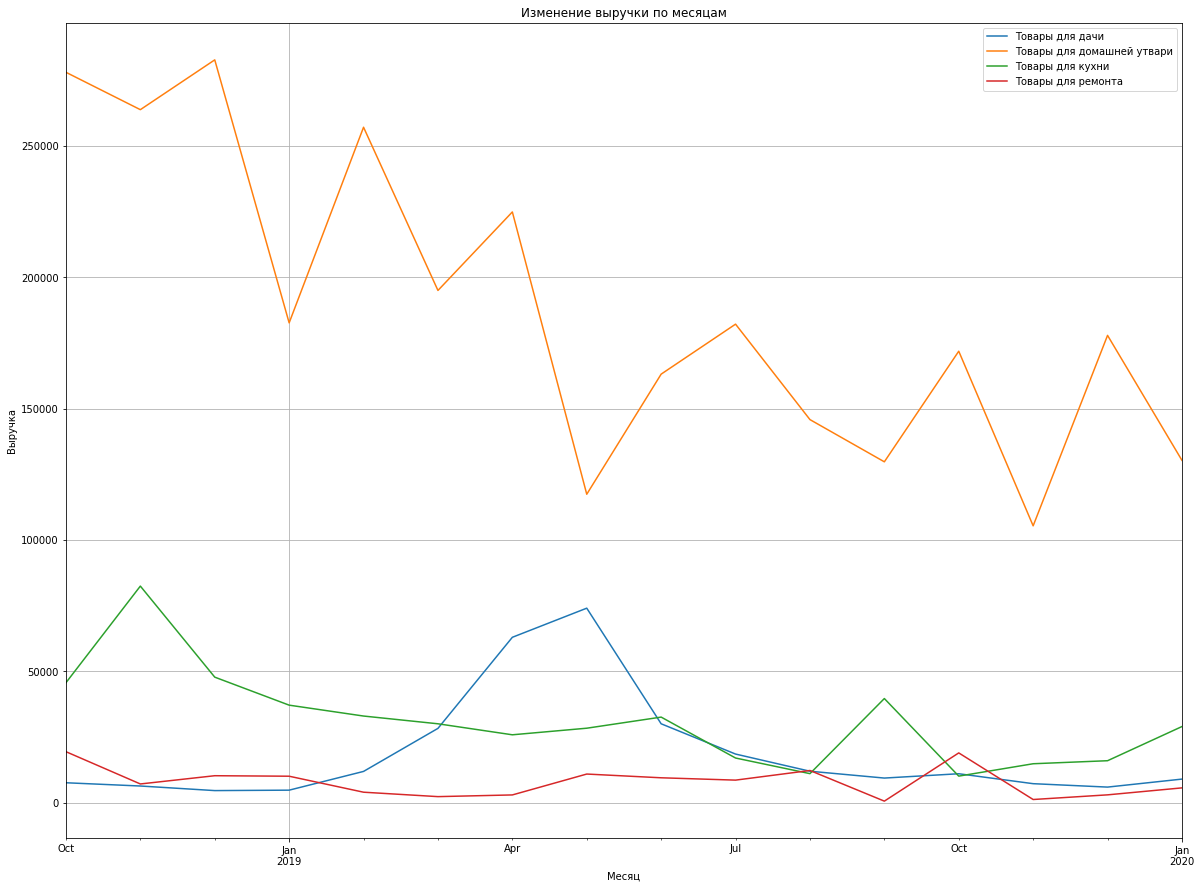

In [63]:
df.pivot_table(
    index='month', 
    columns='cat_product',  
    values='revenue',  
    aggfunc='sum',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение выручки по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

1. У "товаров для домашней утвари" в течении года плавно снижается выручка;
2. "товары для дачи"  - выручка возрастает весной(сезонность);
3. "товары для кухни" - возрастание выручки осенью;
4. "товары для ремонта показывают"- наибольшая выручка осенью, также есть небольшой рост летом - сезонность

**Изменение количества уникальных покупок по месяцам**

In [64]:
df.pivot_table(
    index='month',  
    columns='cat_product',  
    values='order_id',  
    aggfunc='nunique') 

cat_product,Товары для дачи,Товары для домашней утвари,Товары для кухни,Товары для ремонта
month,,,,
2018-10-01,13,187,57,10
2018-11-01,14,154,52,5
2018-12-01,10,206,62,4
2019-01-01,8,122,38,5
2019-02-01,36,214,44,3
2019-03-01,48,178,43,2
2019-04-01,67,212,27,1
2019-05-01,75,108,34,5
2019-06-01,42,118,22,2


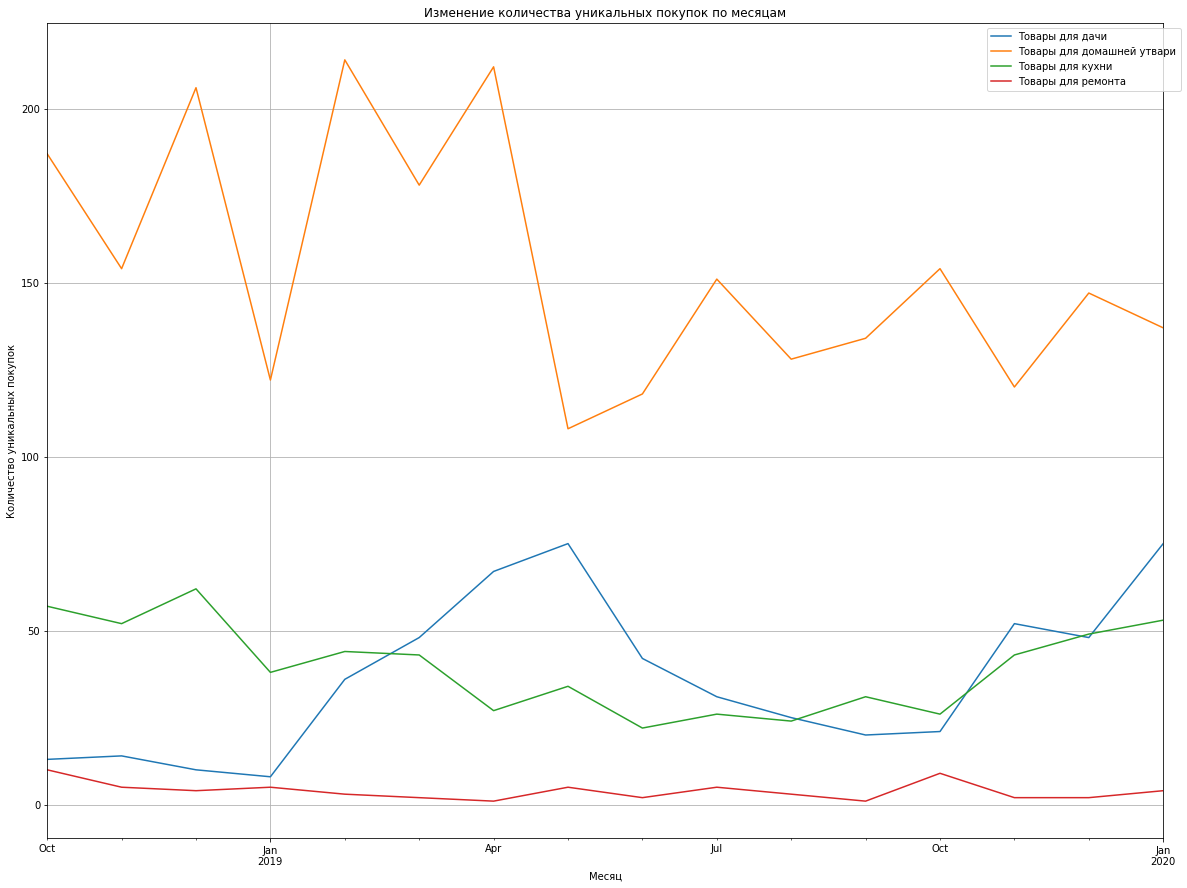

In [65]:
df.pivot_table(
    index='month',  
    columns='cat_product',  
    values='order_id',  
    aggfunc='nunique',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества уникальных покупок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупок')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

1. У "товаров для домашней утвари" большое количество уникальных покупок осень-весна, спад летом, при этом очень сильный спад в январе 2019 года
2. "товары для дачи"  - количество уникальных покупок возрастает весной(сезонность);
3. "товары для кухни" -  большое количество уникальных покупок осень-весна, спад летом;
4. "товары для ремонта показывают"- наибольшее количество уникальных покупок осенью

**Изменение количества уникальных покупателей по месяцам**

In [66]:
df.pivot_table(
    index='month',  
    columns='cat_product',  
    values='customer_id',  
    aggfunc='nunique',  
)

cat_product,Товары для дачи,Товары для домашней утвари,Товары для кухни,Товары для ремонта
month,,,,
2018-10-01,11,141,48,10
2018-11-01,14,134,47,5
2018-12-01,9,168,56,4
2019-01-01,8,108,38,5
2019-02-01,30,185,42,3
2019-03-01,47,169,41,2
2019-04-01,60,191,25,1
2019-05-01,67,101,32,5
2019-06-01,39,111,21,2


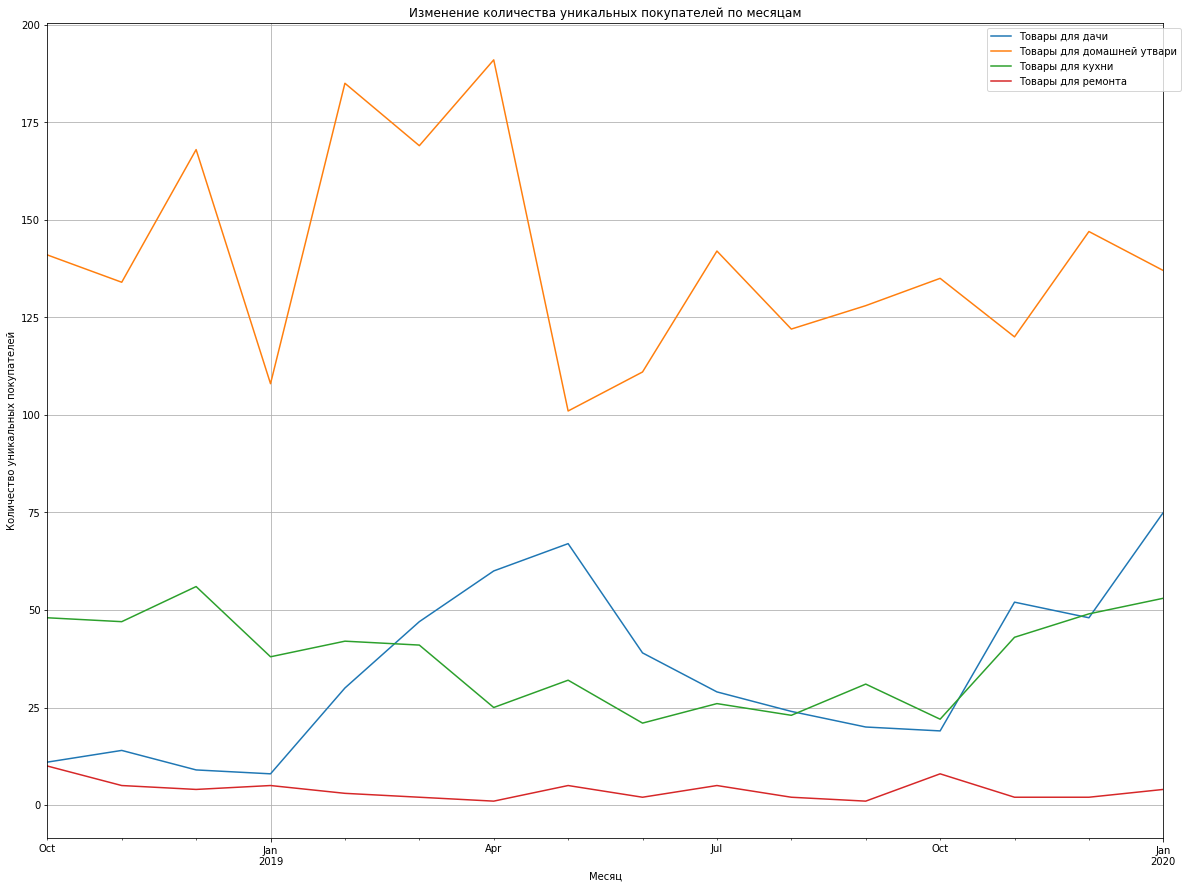

In [67]:
df.pivot_table(
    index='month',  
    columns='cat_product',  
    values='customer_id',  
    aggfunc='nunique',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества уникальных покупателей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных покупателей')
plt.legend(bbox_to_anchor=(1.02, 1.0), loc='best')
plt.show()

Результаты изменения количества уникальных покупателей по месяцам схоже изменением уникальных покупок

**Вывод по категоризации:**

1. провели сегментацию пользователей на основе историй их покупок
2. разбили на категории по группам товаров (Товары для дачи, Товары для домашней утвари, Товары для кухни, Товары для ремонта)
3. Самая большая выручка у категории "Товары для домашней утвари", наибольший средний чек у "Товары для ремонта"
4. У "товаров для домашней утвари" в течении года плавно снижается выручка
   "товары для дачи"  - выручка возрастает весной(сезонность);
   "товары для кухни" - возрастание выручки осенью;
   "товары для ремонта показывают"- наибольшая выручка осенью, также есть небольшой рост летом - сезонность
5. У "товаров для домашней утвари" большое количество уникальных покупок осень-весна, спад летом, при этом очень сильный спад в январе 2019 года
   "товары для дачи"  - количество уникальных покупок возрастает весной(сезонность);
   "товары для кухни" -  большое количество уникальных покупок осень-весна, спад летом;
   "товары для ремонта показывают"- наибольшее количество уникальных покупок осенью
6. Результаты изменения количества уникальных покупателей по месяцам схоже изменением уникальных покупок   
   

<div class="alert alert-block alert-info"> </div>

**Популярность категорий**

In [68]:
#сгруппируем данные по категориям
groupby_category = df.groupby('cat_product').agg({'revenue':'sum', 'date':'max', 'order_id':'nunique',
                                                      'customer_id':'nunique', 'quantity':'sum'})
groupby_category.columns = ['revenue', 'date', 'orders', 'customers', 'quantity'] 

#средний чек покупателя
groupby_category['revenue_per_customer'] = groupby_category['revenue'] / groupby_category['customers']

#средний чек заказов
groupby_category['revenue_per_order'] = groupby_category['revenue'] / groupby_category['orders']
groupby_category = groupby_category.sort_values(by='revenue', ascending = False)

# Найдем соотношение выручки, покупателей, заказов от их общего количества
groupby_category['ratio_revenue'] = ((groupby_category['revenue'] / groupby_category['revenue'].sum())* 100)\
                                                                                    .round(1).astype('str')+'%'
groupby_category['ratio_customer']= ((groupby_category['customers'] / groupby_category['customers'].sum())* 100)\
                                                                                     .round(1).astype('str')+'%'
groupby_category['ratio_order']= ((groupby_category['orders'] / groupby_category['orders'].sum())* 100)\
                                                                                     .round(1).astype('str')+'%'
display(groupby_category)

,revenue,date,orders,customers,quantity,revenue_per_customer,revenue_per_order,ratio_revenue,ratio_customer,ratio_order
cat_product,,,,,,,,,,
Товары для домашней утвари,3.007493e+06,2020-01-31 15:00:00,2468,1910,8160,1574.603796,1218.595320,76.3%,62.6%,65.9%
Товары для кухни,5.009790e+05,2020-01-29 17:00:00,631,568,2060,882.005282,793.944532,12.7%,18.6%,16.8%
Товары для дачи,3.042038e+05,2020-01-31 12:00:00,584,517,2611,588.401999,520.896975,7.7%,16.9%,15.6%
Товары для ремонта,1.274383e+05,2020-01-22 19:00:00,63,58,533,2197.212644,2022.830688,3.2%,1.9%,1.7%


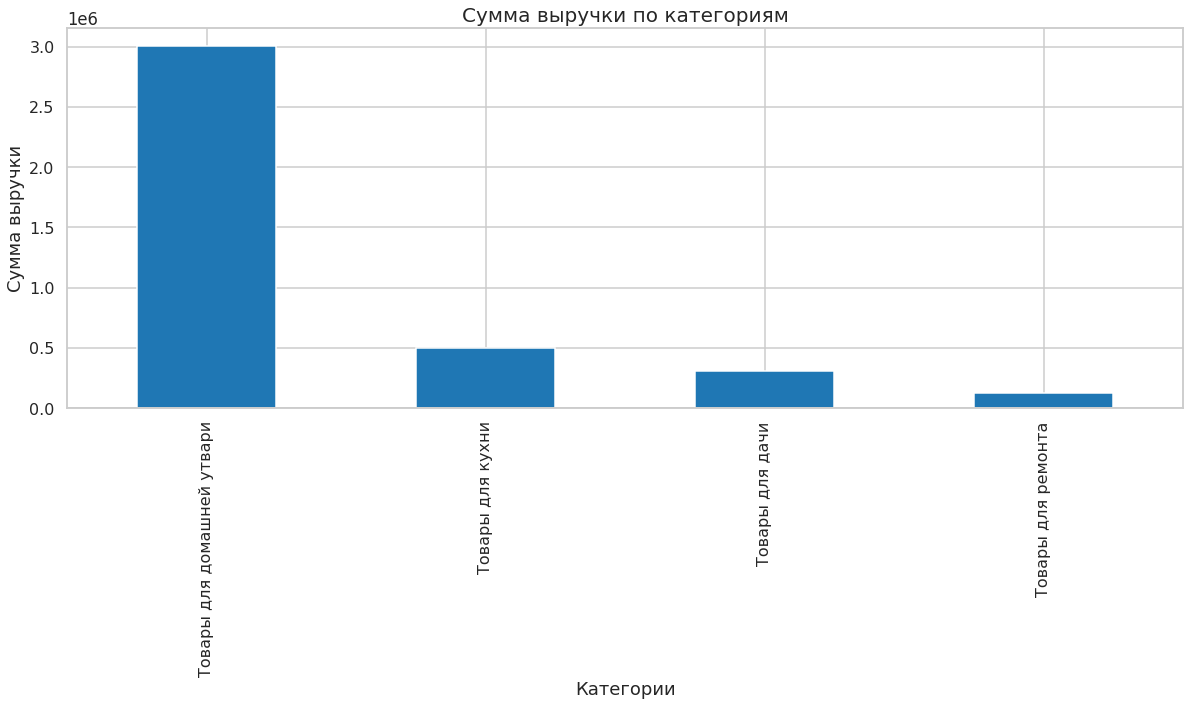

In [69]:
#график по сумме выручки по категориям
sns.set_style('whitegrid')
sns.set_context('talk')
groupby_category.plot(kind='bar', y=['revenue'], figsize=(20,7), grid=True, 
                      fontsize=16, legend=False)
plt.title('Сумма выручки по категориям', fontsize=20)
plt.xlabel('Категории')
plt.ylabel('Cумма выручки')
plt.show()

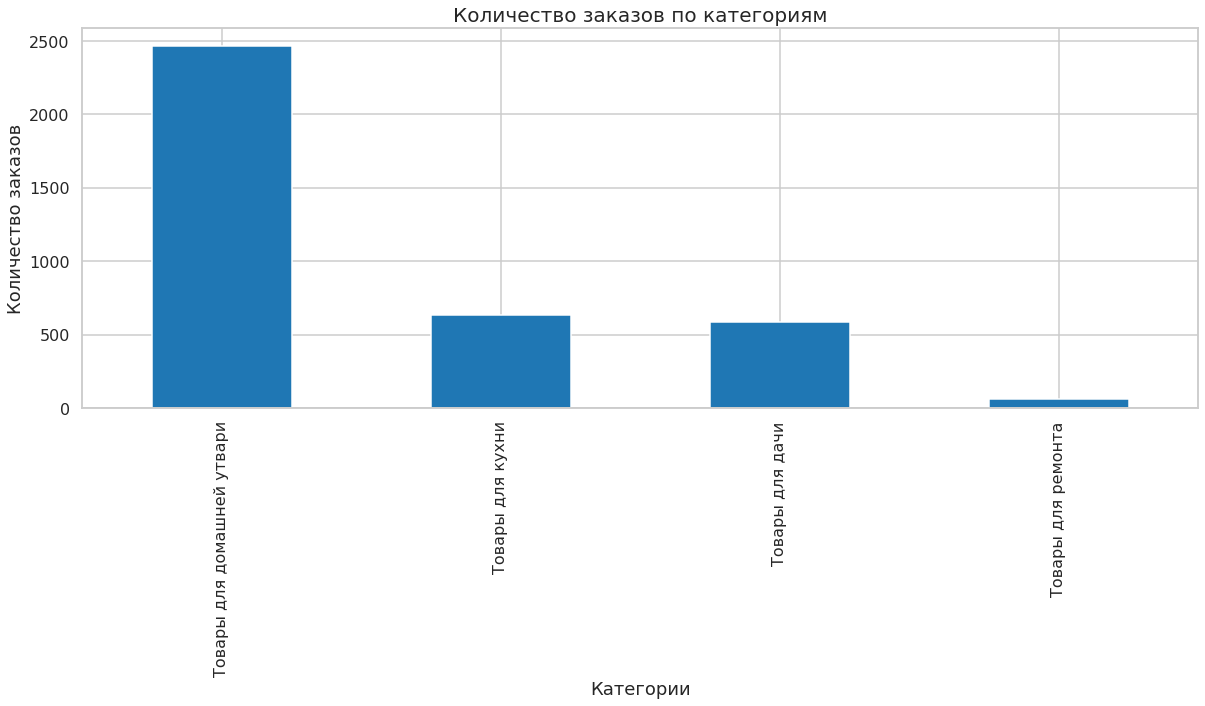

In [70]:
# график по количеству заказов по категориям
sns.set_style('whitegrid')
sns.set_context('talk')
groupby_category.plot(kind='bar', y=['orders'], figsize=(20,7), grid=True, 
                      fontsize=16, legend=False)
plt.title('Количество заказов по категориям', fontsize=20)
plt.xlabel('Категории')
plt.ylabel('Количество заказов')
plt.show()

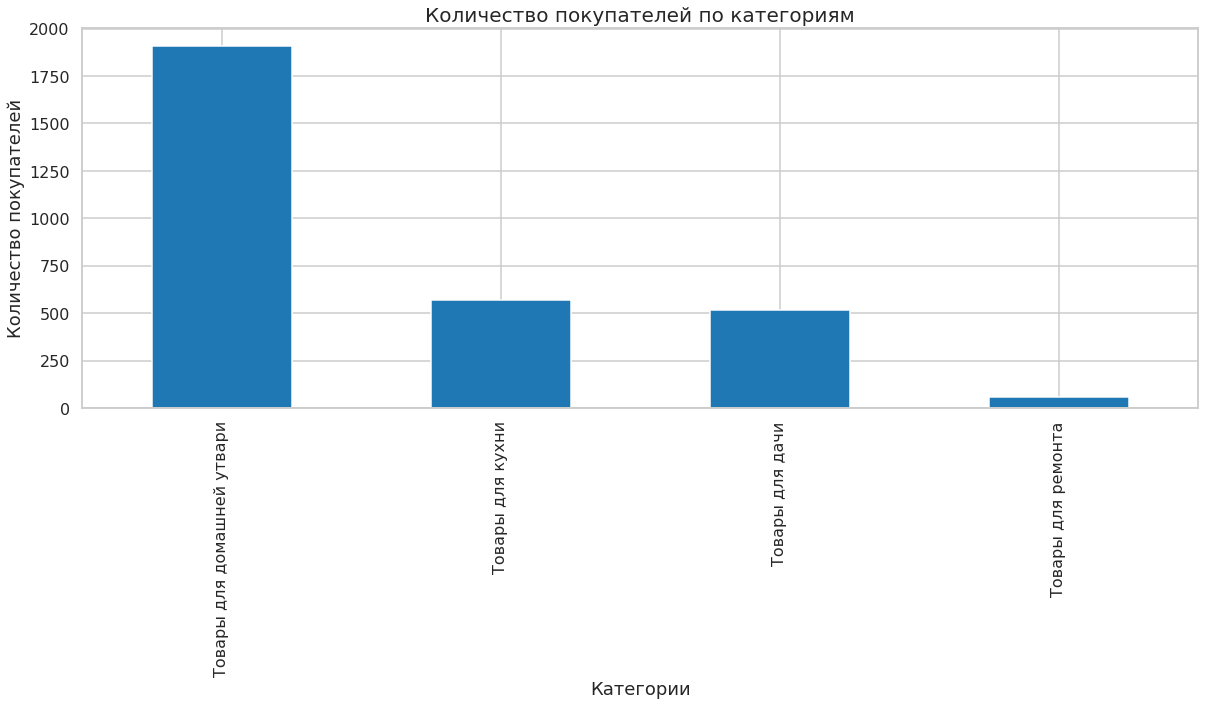

In [71]:
# график по количествуву покупателей по категориям
sns.set_style('whitegrid')
sns.set_context('talk')
groupby_category.plot(kind='bar', y=['customers'], figsize=(20,7), grid=True, 
                      fontsize=16, legend=False)
plt.title('Количество покупателей по категориям', fontsize=20)
plt.xlabel('Категории')
plt.ylabel('Количество покупателей')
plt.show()

Наиболее популярная категория "Товары для домашней утвари" - по сумме выручки, по кличеству заказов и покупателей, наименее "Товары для ремонта"

<div class="alert alert-block alert-info"> </div>

<div class="alert alert-block alert-info"> </div>

**Кластеризация**

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5553 entries, 0 to 7473
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         5553 non-null   datetime64[ns]
 1   customer_id  5553 non-null   object        
 2   order_id     5553 non-null   int64         
 3   product      5553 non-null   object        
 4   quantity     5553 non-null   int64         
 5   price        5553 non-null   float64       
 6   revenue      5553 non-null   float64       
 7   month        5553 non-null   datetime64[ns]
 8   cat_product  5553 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 433.8+ KB


Выделим кластеры по следующим признакам:
1. количество товаров в заказе
2. среднему прайсу
3. по выручке
4. количеству заказов
5. среднему чеку заказа

In [73]:
df_clust = df.groupby('customer_id').agg({
    'quantity': 'sum', #количество товаров в заказе
    'price': 'mean', #средний прайс
    'revenue': 'sum', #выручка
    'order_id': 'count' #количество заказов
}).reset_index().fillna(0)
df_clust['price'] = df_clust['price'].round(1)
df_clust['revenue_per_order'] = (df_clust['revenue'] / df_clust['order_id']).round(1)
df_clust.columns = ['customer_id', 'количество_товаров_в_заказе', 'средний_прайс', 'выручка', 'количество_заказов', 'средний_чек']
df_clust['среднее_количество_товаров_в_заказе'] = (df_clust['количество_товаров_в_заказе'] / df_clust['количество_заказов']).round(1)
df_clust

,customer_id,количество_товаров_в_заказе,средний_прайс,выручка,количество_заказов,средний_чек,среднее_количество_товаров_в_заказе
0,000d6849-084e-4d9f-ac03-37174eaf60c4,4,138.8,555.0,4,138.8,1.0
1,001cee7f-0b29-4716-b202-0042213ab038,1,442.0,442.0,1,442.0,1.0
2,00299f34-5385-4d13-9aea-c80b81658e1b,2,457.0,914.0,1,914.0,2.0
3,002d4d3a-4a59-406b-86ec-c3314357e498,1,1649.0,1649.0,1,1649.0,1.0
4,003bbd39-0000-41ff-b7f9-2ddaec152037,2,1162.0,2324.0,1,2324.0,2.0
...,...,...,...,...,...,...,...
2424,ff601403-b094-4b86-9ac6-264d725b9277,2,869.5,1739.0,2,869.5,1.0
2425,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,1,397.0,397.0,1,397.0,1.0
2426,ffb5976a-7a4d-460b-95c4-5ffaba31cb24,1,389.0,389.0,1,389.0,1.0
2427,ffb80538-3fda-4351-8ea9-9d2bec58bb07,1,974.0,974.0,1,974.0,1.0


Прверим новые столбцы на выбросы

In [74]:
df_clust['средний_прайс'].describe()

count     2429.000000
mean       713.957061
std       1026.188724
min         14.000000
25%        134.000000
50%        340.500000
75%        899.500000
max      14917.000000
Name: средний_прайс, dtype: float64

In [75]:
df_clust['средний_прайс'].quantile([0.25, 0.5, 0.99 ])

0.25     134.0
0.50     340.5
0.99    5025.2
Name: средний_прайс, dtype: float64

In [76]:
df_clust= df_clust.query('средний_прайс < 5000')
df_clust['средний_прайс'].describe()

count    2404.000000
mean      651.524002
std       804.402582
min        14.000000
25%       134.000000
50%       333.250000
75%       899.000000
max      4874.000000
Name: средний_прайс, dtype: float64

In [77]:
df_clust['количество_товаров_в_заказе'].describe()

count    2404.000000
mean        5.546173
std        18.123012
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       334.000000
Name: количество_товаров_в_заказе, dtype: float64

In [78]:
df_clust['количество_товаров_в_заказе'].quantile([0.25, 0.5, 0.99 ])

0.25     1.0
0.50     2.0
0.99    60.0
Name: количество_товаров_в_заказе, dtype: float64

In [79]:
df_clust= df_clust.query('количество_товаров_в_заказе < 60')
df_clust['количество_товаров_в_заказе'].describe()

count    2378.000000
mean        4.107233
std         6.633683
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        59.000000
Name: количество_товаров_в_заказе, dtype: float64

In [80]:
df_clust['выручка'].describe()

count     2378.000000
mean      1385.966534
std       2119.555284
min         15.000000
25%        380.500000
50%        823.000000
75%       1722.250000
max      53232.000000
Name: выручка, dtype: float64

In [81]:
df_clust['выручка'].quantile([0.25, 0.5, 0.99 ])

0.25     380.50
0.50     823.00
0.99    7959.89
Name: выручка, dtype: float64

In [82]:
df_clust= df_clust.query('выручка < 7959.89')
df_clust['выручка'].describe()

count    2354.000000
mean     1251.054977
std      1286.799079
min        15.000000
25%       376.000000
50%       806.500000
75%      1659.250000
max      7950.000000
Name: выручка, dtype: float64

In [83]:
df_clust['средний_чек'].describe()

count    2354.000000
mean      820.328122
std       946.542123
min        15.000000
25%       194.625000
50%       480.000000
75%      1065.750000
max      7870.000000
Name: средний_чек, dtype: float64

In [84]:
df_clust['средний_чек'].quantile([0.25, 0.5, 0.99 ])

0.25     194.625
0.50     480.000
0.99    4405.980
Name: средний_чек, dtype: float64

In [85]:
df_clust= df_clust.query('средний_чек < 4405.98')
df_clust['средний_чек'].describe()

count    2330.000000
mean      772.171845
std       815.669322
min        15.000000
25%       193.700000
50%       475.750000
75%      1049.000000
max      4390.000000
Name: средний_чек, dtype: float64

In [86]:
df_clust['количество_заказов'].describe()

count    2330.000000
mean        2.199571
std         3.126927
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        51.000000
Name: количество_заказов, dtype: float64

In [87]:
df_clust['количество_заказов'].quantile([0.25, 0.5, 0.99 ])

0.25     1.0
0.50     2.0
0.99    17.0
Name: количество_заказов, dtype: float64

In [88]:
df_clust= df_clust.query('количество_заказов < 17')
df_clust['количество_заказов'].describe()

count    2303.000000
mean        1.941381
std         1.865025
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        16.000000
Name: количество_заказов, dtype: float64

In [89]:
X = df_clust.drop('customer_id', axis=1)
y = df_clust['customer_id']

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =0)

In [91]:
# стандартизация данных
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#Построение матрицы расстояний
linked = linkage(X_sc, method = 'ward')

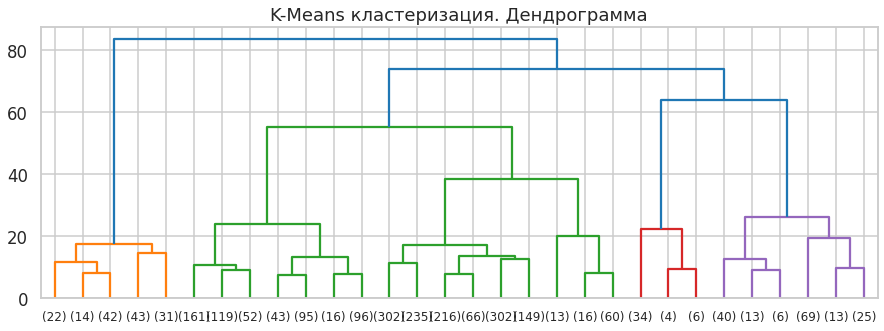

In [92]:

plt.figure(figsize=(15, 5))  
dendrogram(linked, orientation='top',
           truncate_mode='lastp',  
           p=30,  
           leaf_rotation=0,
           leaf_font_size=12)     
plt.title('K-Means кластеризация. Дендрограмма', size=18)
plt.show() 

In [93]:
km = KMeans(n_clusters = 4, random_state=0, n_jobs=1) # задаём число кластеров, равное 4
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров 

In [94]:
# сохраняем метки кластера в поле нашего датасета
df_clust['cluster_km'] = labels

In [95]:
clusters = df_clust.groupby('cluster_km').mean().T.iloc[:6]

In [96]:
clusters

cluster_km,0,1,2,3
количество_товаров_в_заказе,1.899743,2.438882,25.360000,12.685950
средний_прайс,1966.855013,389.724214,69.724000,129.563636
выручка,3184.112254,700.836874,1518.360000,1498.884298
количество_заказов,1.534704,1.583818,1.200000,8.785124
средний_чек,2182.543445,478.722526,1371.670667,178.977686
среднее_количество_товаров_в_заказе,1.327249,1.738999,22.969333,1.520661


1. Кластер 0 - разовый покупатель с высоким чеком
2. Кластер 1 - разовый покупатель с низким чеком
3. Кластер 2 - потенциальный оптовик
4. Кластер 3 - оптовик

**Поведение покупателей из разных кластеров после сегментации**

In [97]:
df = df.merge(df_clust, left_on='customer_id', right_on='customer_id')

In [98]:
orders_filt_clust = df.groupby('cluster_km')\
.agg({'customer_id':'nunique', 'order_id':'nunique', 'product':'count', 'quantity':'sum', 'price':'mean', 
      'revenue':'sum'}).reset_index()

In [99]:
orders_filt_clust['avg_orders_per_buyer'] = round(orders_filt_clust['order_id']/orders_filt_clust['customer_id'],0)
orders_filt_clust['avg_bill'] = orders_filt_clust['revenue'] / orders_filt_clust['order_id']
orders_filt_clust['avg_goods_per_buyer'] = round(orders_filt_clust['quantity'] / orders_filt_clust['customer_id'], 0)

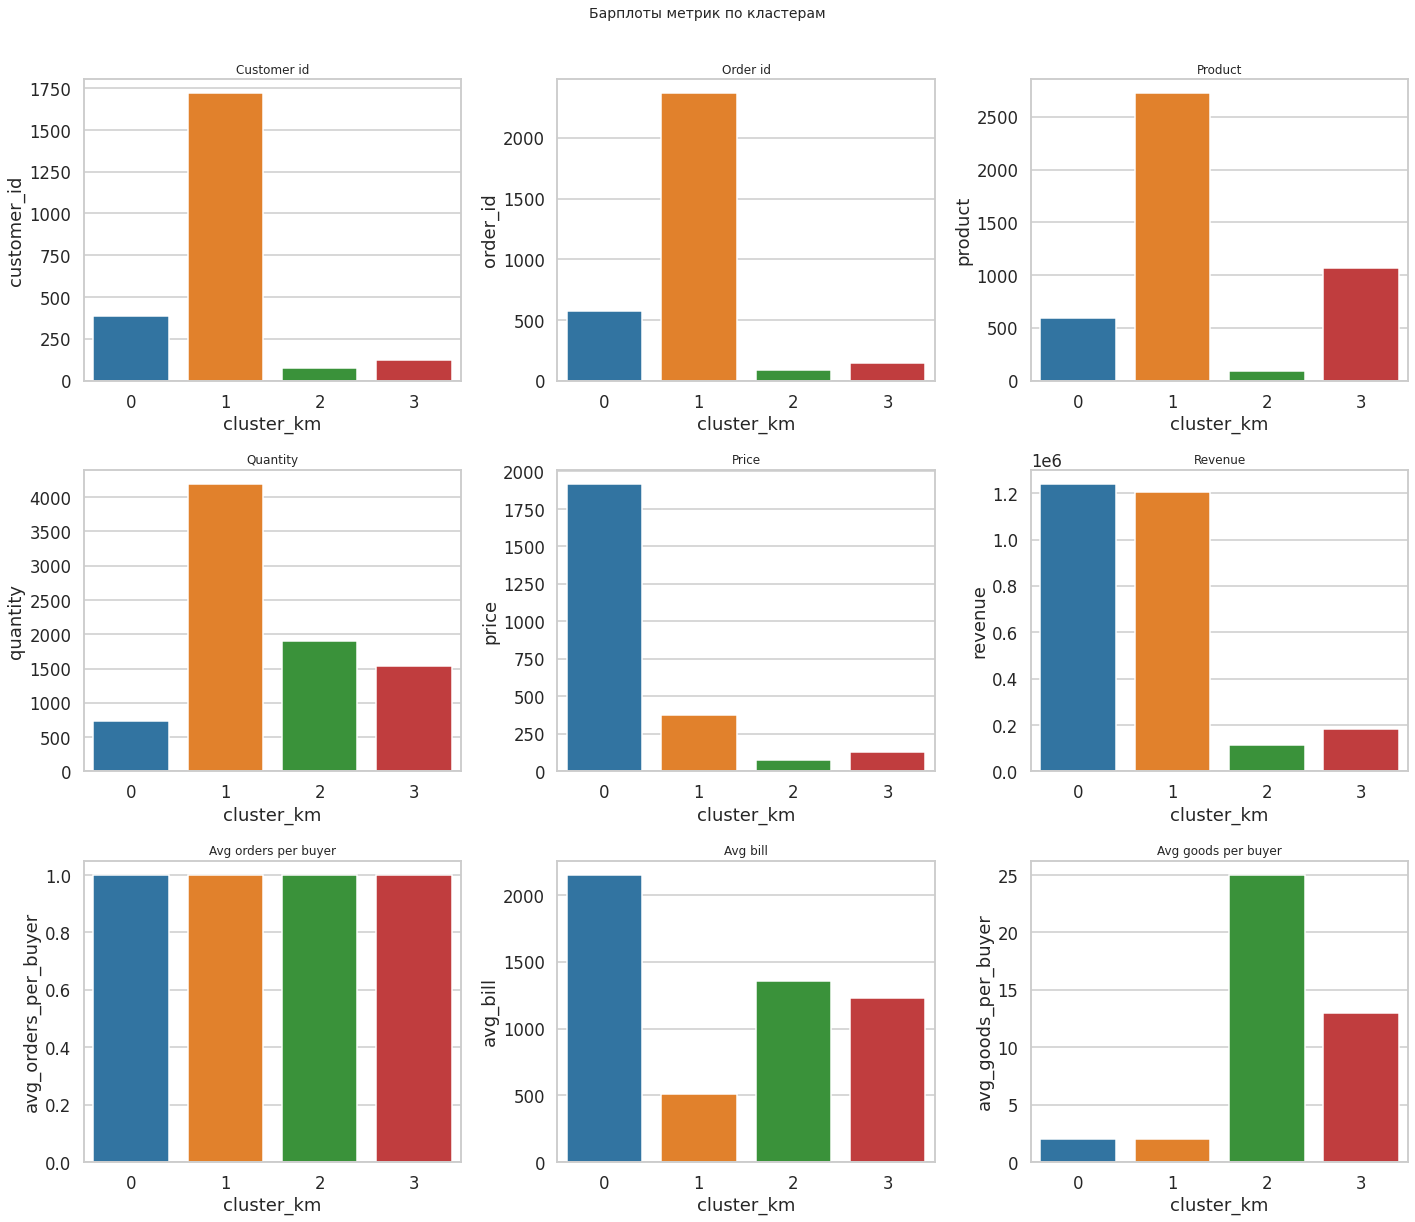

In [100]:
WIDTH = 3
plot_amount = len(orders_filt_clust.columns)
height = plot_amount//WIDTH

fig, axs = plt.subplots(height, WIDTH, figsize=(20, 17))
fig.suptitle('Барплоты метрик по кластерам',  y=1.003, size=14)

for item, ax in zip(orders_filt_clust.columns[1:], np.ravel(axs)):
    sns.barplot(data = orders_filt_clust, x='cluster_km', y=item, ax=ax)
    ax.set_title(item.capitalize().replace('_', ' '), size=12)

plt.tight_layout()
plt.show()

*Кластер 0:* 
1. среднее число заказов маленькое - всего один 
2. средний чек -  самый низкий
3. среднее количество товаров в корзине - маленькое

<div class="alert alert-block alert-info"> </div>

<div class="alert alert-block alert-info"> </div>

**Сезонность категорий по кластерам**

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4471 entries, 0 to 4470
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 4471 non-null   datetime64[ns]
 1   customer_id                          4471 non-null   object        
 2   order_id                             4471 non-null   int64         
 3   product                              4471 non-null   object        
 4   quantity                             4471 non-null   int64         
 5   price                                4471 non-null   float64       
 6   revenue                              4471 non-null   float64       
 7   month                                4471 non-null   datetime64[ns]
 8   cat_product                          4471 non-null   object        
 9   количество_товаров_в_заказе          4471 non-null   int64         
 10  средний_прай

Для кластера 0

In [102]:
df['cluster_km']=df['cluster_km'].astype(float)

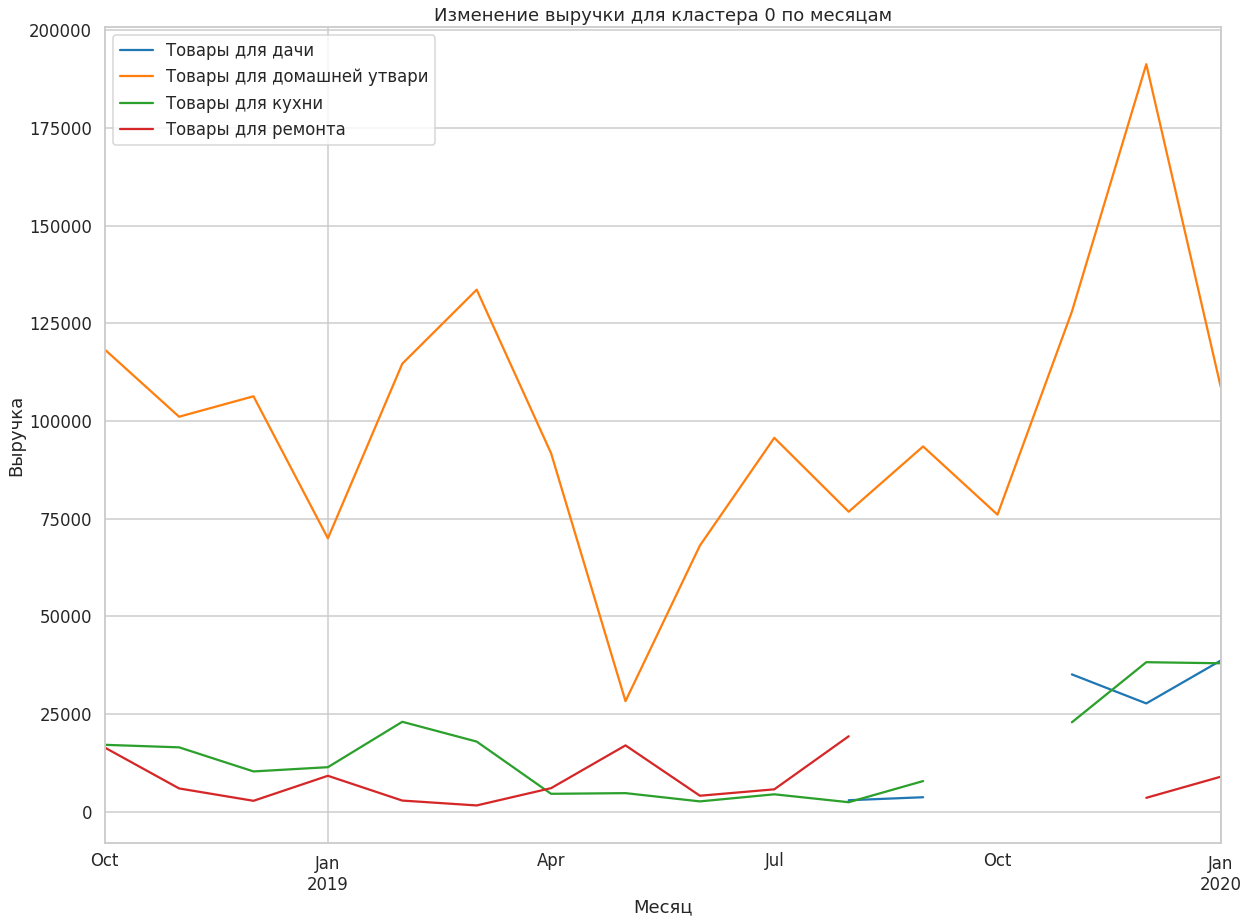

In [103]:
cl0 = df.query('cluster_km ==0')

cl0.pivot_table(
    index='month', 
    columns='cat_product',  
    values='выручка',  
    aggfunc='sum',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение выручки для кластера 0 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

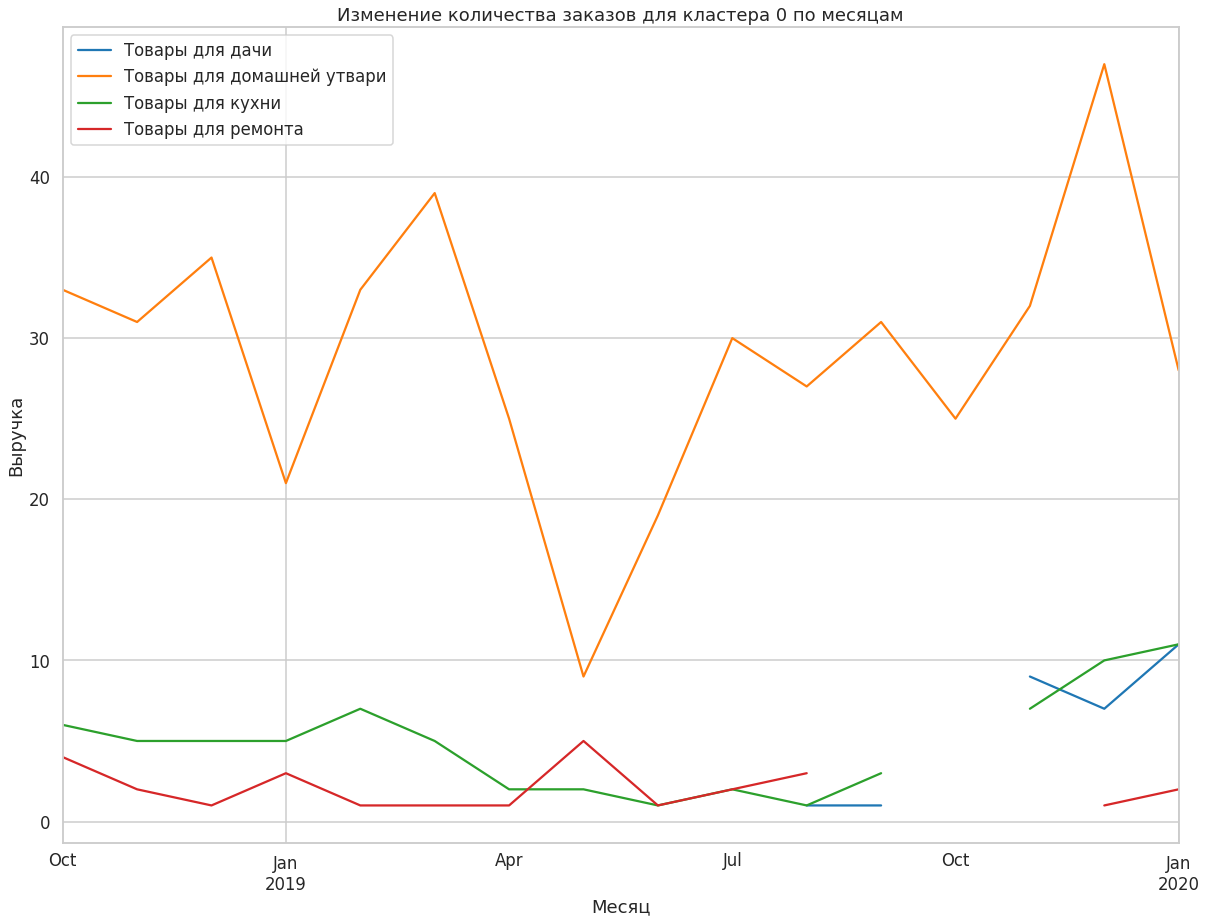

In [104]:
cl0 = df.query('cluster_km ==0')

cl0.pivot_table(
    index='month', 
    columns='cat_product',  
    values='количество_заказов',  
    aggfunc='count',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества заказов для кластера 0 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

1. Кластер 0 в основном предпочитаем категорию "Товары для домашней утвари", менее "Для Кухни" и "Для ремонта"
2. В целом выручка и количество заказов возрастает в осенне-зимний период
3. Достаточно большая выручка, но мало товаров в заказе

*Рекомендация для кластера 0:*
1. проводить рекламные кампании в осенне-зимний период, так как выручка в этот период наибольшая
2. улучшить кросс-продажи для увеличения количества товаров в заказе

Для кластера 1

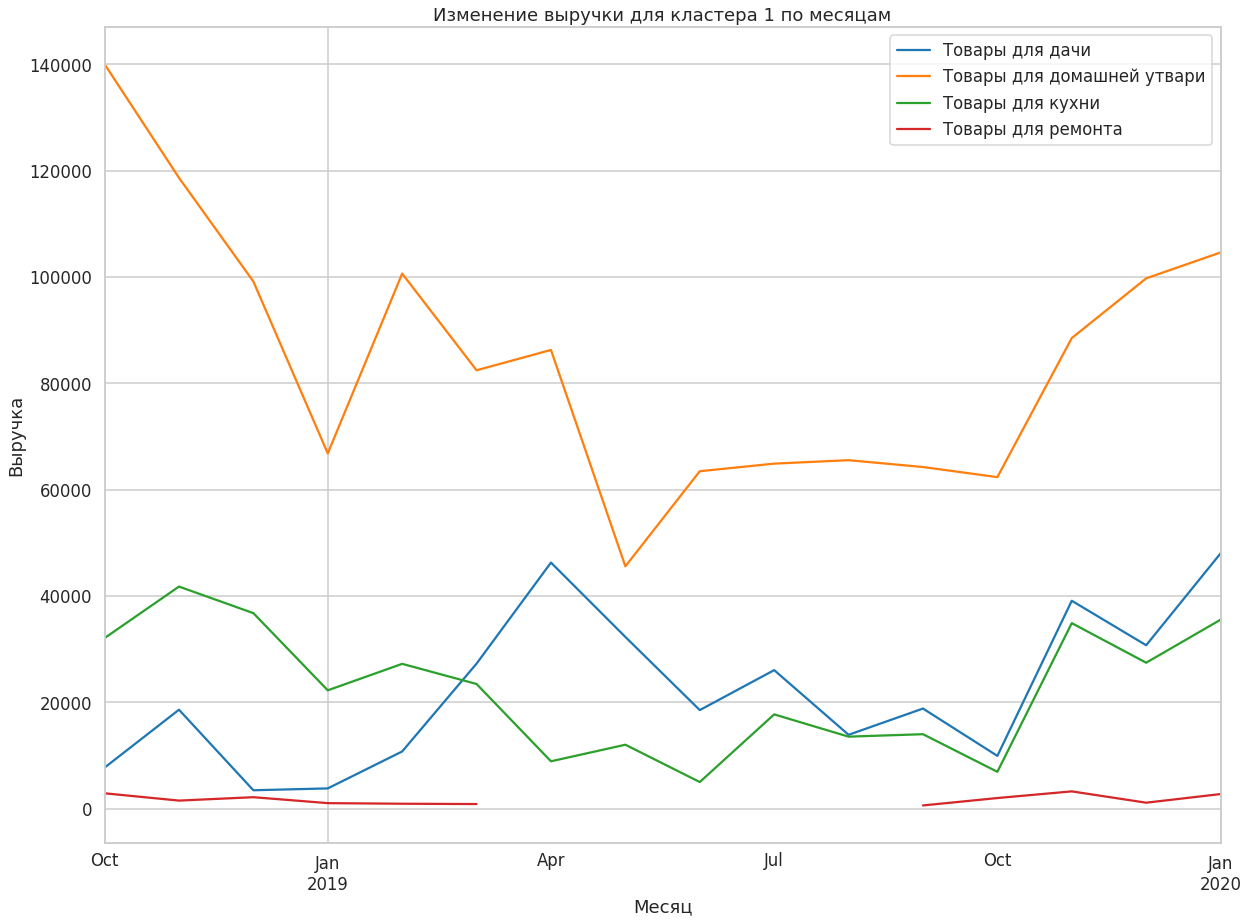

In [105]:
cl1 = df.query('cluster_km ==1')

cl1.pivot_table(
    index='month', 
    columns='cat_product',  
    values='выручка',  
    aggfunc='sum',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение выручки для кластера 1 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

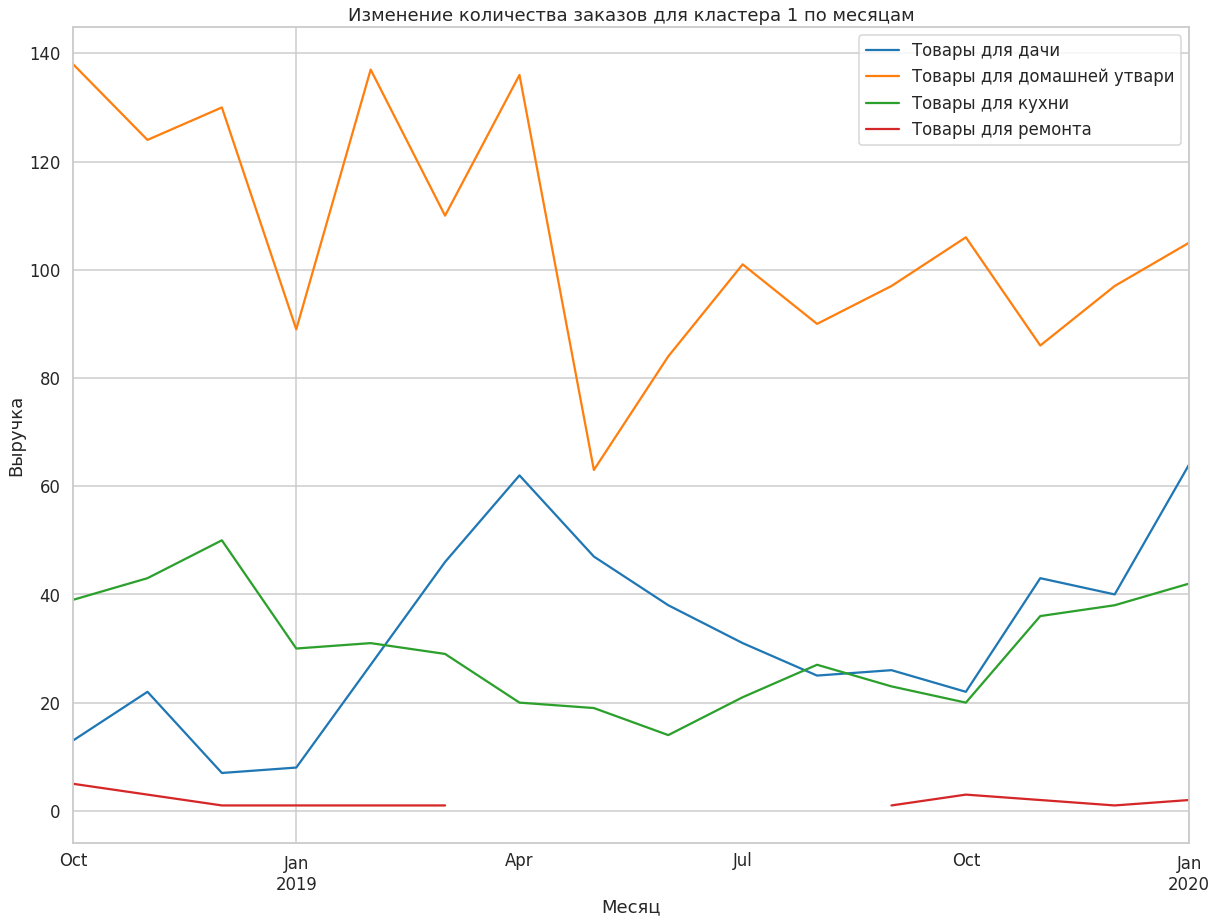

In [106]:
cl1 = df.query('cluster_km ==1')

cl1.pivot_table(
    index='month', 
    columns='cat_product',  
    values='количество_заказов',  
    aggfunc='count',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества заказов для кластера 1 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

1. Кластер 1 в основном предпочитаем категорию "Товары для домашней утвари", "Для дачи" и "Для кухни"
2. Всплеск интереса к группе "Для дачи"  в весенний период и к группе "Для кухни" в осенний
3. Маленькая выручка и меленький средний чек, малое количество товаров в заказе

*Рекомендация для кластера 1:*
1. проводить рекламные кампании в осенне-зимний период по категории "Товары для домашней утвари" и "Для кухни" , так как выручка в этот период наибольшая, в весенний период на "Товары для дачи"
2. улучшить кросс-продажи для увеличения количества товаров в заказе
3. продумать варианты увеличения среднего чека для этого кластера, так как он наиболее массовый
4. большую часть бюджета ориентировать на этот кластер, так как он наиболее массовый

Для кластера 2

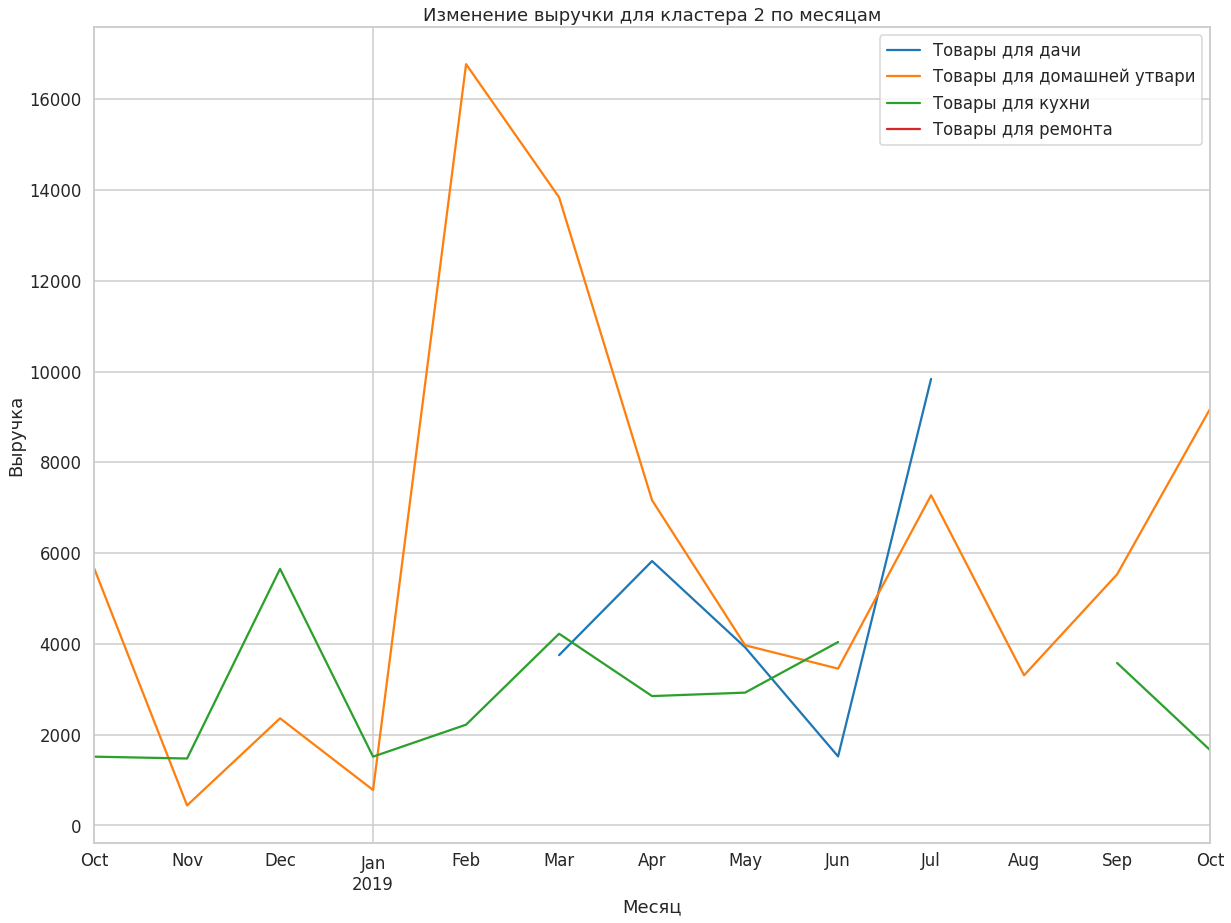

In [107]:
cl2 = df.query('cluster_km ==2')

cl2.pivot_table(
    index='month', 
    columns='cat_product',  
    values='выручка',  
    aggfunc='sum',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение выручки для кластера 2 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

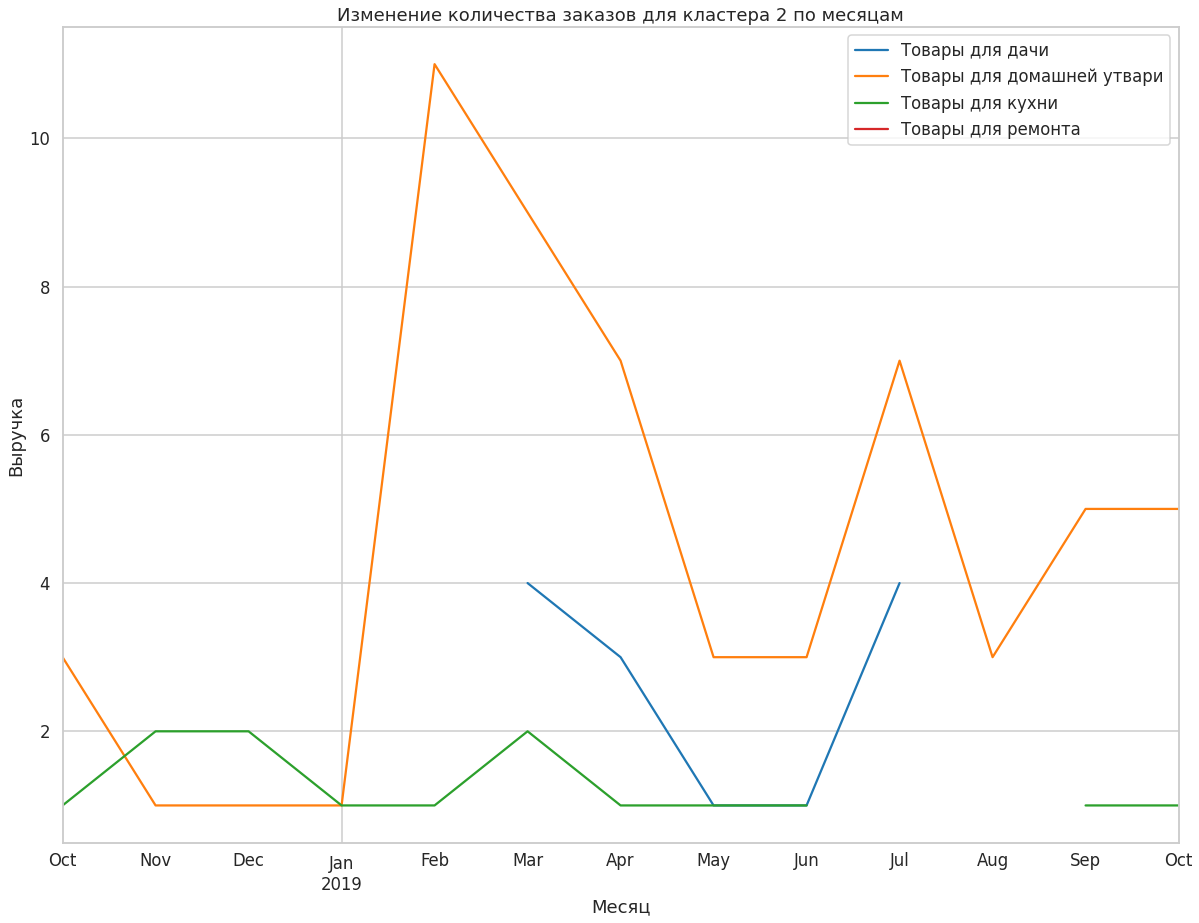

In [108]:
cl2 = df.query('cluster_km ==2')

cl2.pivot_table(
    index='month', 
    columns='cat_product',  
    values='количество_заказов',  
    aggfunc='count',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества заказов для кластера 2 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

1. Кластер 2 в основном предпочитаем категорию "Товары для домашней утвари"
2. Всплеск интереса к группе "Товары для домашней утвари" в весенний период
3. Данный кластер совершает разово покупки с большим количеством товаров в заказе

Рекомендация для кластера 2:

1. изучить более подробно опыт в рекламе для категории "Для доашней утвари" так как скорее всего имело место хорошее торговое предложение, которые привлекало разово людей совершить покупки с большим количеством товара
2. продумать акцию для "Для домашней утвари" для привлечения новых клиентов и акцию для возврата старых клиентов
3. изучить при общении с данными клиентами не яваляются ли они оптовиками и провести работу с этим кластером более внимательно

Для кластера 3

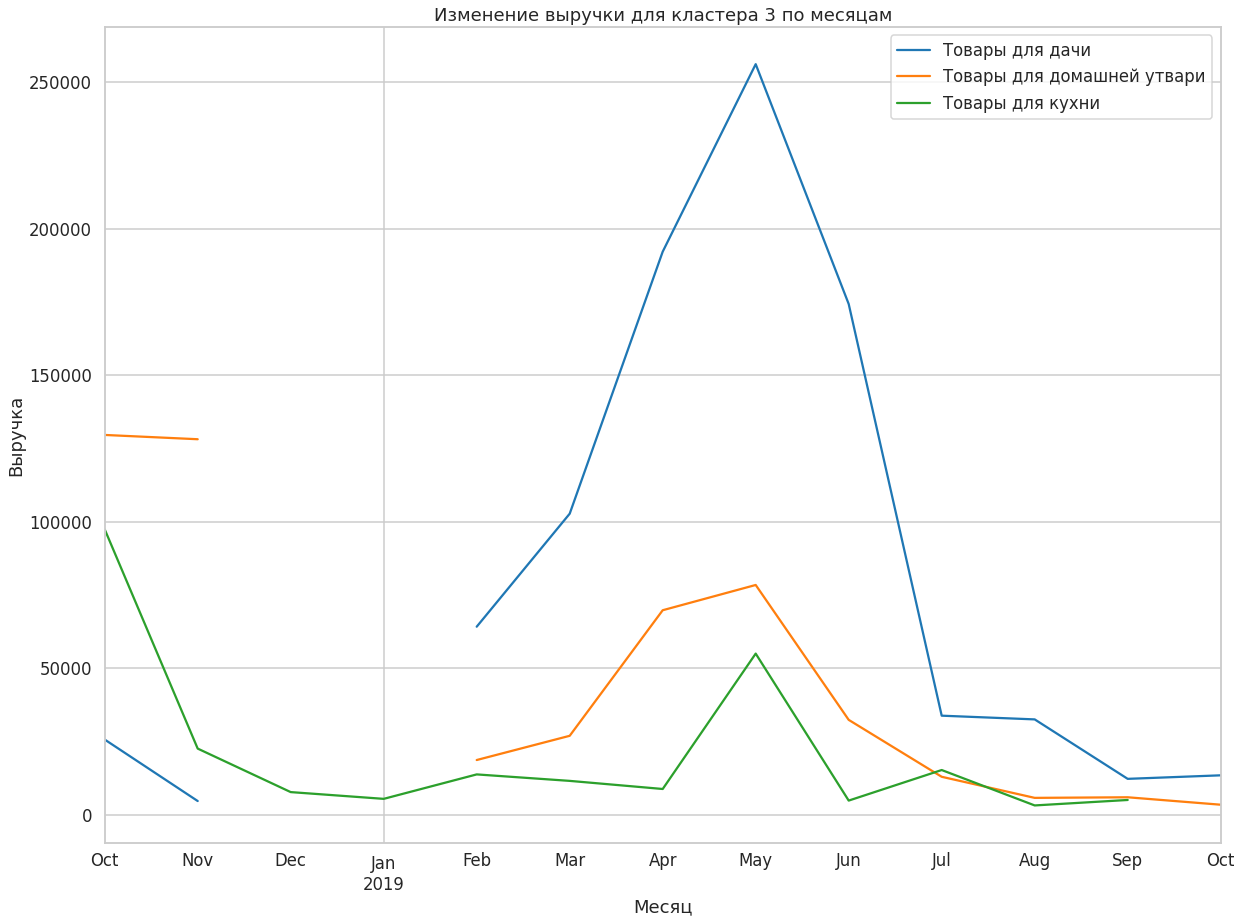

In [109]:
cl3 = df.query('cluster_km ==3')

cl3.pivot_table(
    index='month', 
    columns='cat_product',  
    values='выручка',  
    aggfunc='sum',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение выручки для кластера 3 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

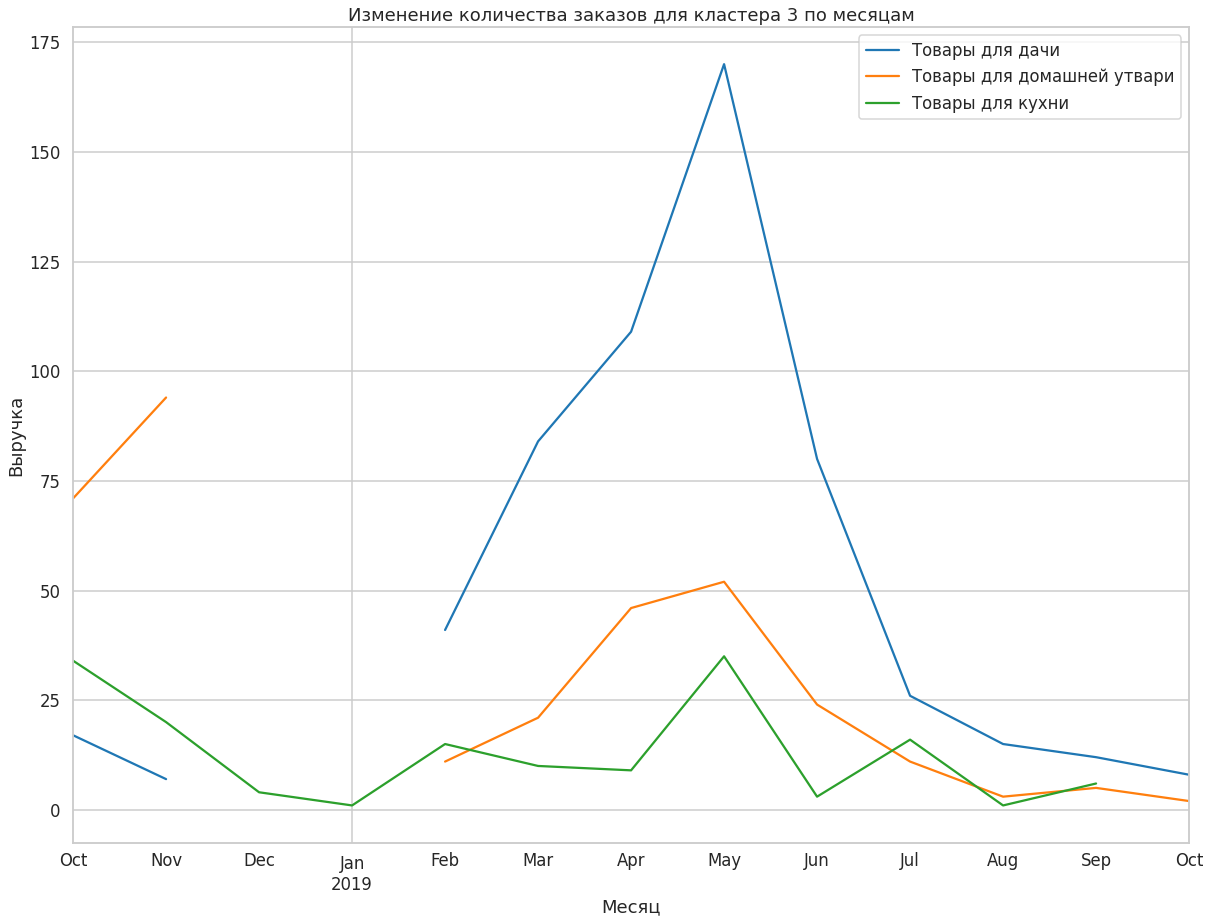

In [110]:
cl3 = df.query('cluster_km ==3')

cl3.pivot_table(
    index='month', 
    columns='cat_product',  
    values='количество_заказов',  
    aggfunc='count',  
).plot(figsize=(20, 15), grid=True)

plt.title('Изменение количества заказов для кластера 3 по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Выручка')
plt.legend(loc='best')
plt.show()

1. Кластер 3 в основном предпочитаем категорию "Товары для дачи"
2. Всплеск интереса к группе "Товары для дачи" в весенний период
3. Данный кластер совершает часто покупки с большим количеством товаров в заказе

Рекомендация для кластера 3:

1. изучить более подробно опыт в рекламе для категории "Для дачи" так как скорее всего имело место хорошее торговое предложение, которые привлекало разово людей совершить покупки с большим количеством товара
2. проводить рекламную кампанию в весенний период
3. подумать над расширением ассортимента в сезон в товарной группе "Товары для дачи"
4. изучить при общении с данными клиентами не яваляются ли они оптовиками и провести работу с этим кластером более внимательно

<div class="alert alert-block alert-info"> </div>

***4.Проверка статистических гипотез***<a id="stat"></a>

**Гипотеза 1**

H0 *Нулевая гипотеза:* Различия в выручке между сегментами покупателей отсутствуют

H1 *Альтернативная гипотеза:* Различия в выручке между сегментами покупателей имеются

Используем критерий Манн-Уиттни, так как он не предполагает что распределение данных нормальное и позволяет выявлять различия в значении параметра между малыми выборками

Критический уровень статистической значимости: Alpha = 0.05 В дальнейшем мы будем корректировать критический уровень статистической значимости используя поправку Шидака для случая множественной проверки гипотез

In [111]:
orders = df.groupby(['customer_id', 'cluster_km']).agg({'revenue':'sum'}).reset_index()

In [112]:
test_pairs_list = list(itertools.combinations([0, 1, 2, 3], 2))
print(test_pairs_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [113]:
p_data = []
for pair_names in test_pairs_list:
    group1 = pair_names[0]
    group2 = pair_names[1]
    pvals = (stats.mannwhitneyu(orders[orders['cluster_km']==group1]['revenue'], 
                                orders[orders['cluster_km']==group2]['revenue'], alternative='two-sided')[1])
    p_data.append(pvals)
    multitest_result = multipletests(p_data, 0.05, method='sidak')

In [114]:
for pair_names, test_status, corrected_p in zip(test_pairs_list, multitest_result[0], multitest_result[1]):
    print('Пара кластеров', pair_names)
    print('alpha с поправкой Шидака: ', multitest_result[2])
    if test_status:
        print('Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, значимые различия между сравниваемыми выборками отсутствуют') 
    print('p-значение после корректировки: ', corrected_p)  
    print('Относительные различия в среднем чеке между группами: {0:.3f}'\
   .format(orders[orders['cluster_km']==pair_names[0]]['revenue'].mean()/orders[orders['cluster_km']==pair_names[1]]['revenue']\
           .mean()-1))
    print()

Пара кластеров (0, 1)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  9.479675927873189e-196
Относительные различия в среднем чеке между группами: 3.543

Пара кластеров (0, 2)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  4.2332670932675334e-21
Относительные различия в среднем чеке между группами: 1.097

Пара кластеров (0, 3)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  1.4344259702645024e-38
Относительные различия в среднем чеке между группами: 1.124

Пара кластеров (1, 2)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  1.3483264206

**Вывод:** между парами перспективных кластеров нулевые гипотезы отверглись, что означает: значимые различия в среднем чеке между сравниваемыми выборками есть, кроме кластера 2 и 3

<div class="alert alert-success">
  
  <b>Комментарий тимлида v.5</b>
    
  ✔️ Молодец, что обращаешь внимание на множественную проверку гипотез!
    
</div>

<div class="alert alert-block alert-info"> </div>

<div class="alert alert-block alert-info"> </div>

**Гипотеза 2**

H0 *Нулевая гипотеза:* Различия в количестве товара в заказе между сегментами покупателей отсутствуют

H1 *Альтернативная гипотеза:* Различия в количестве товара в заказе между сегментами покупателей имеются

Критический уровень статистической значимости: Alpha = 0.05 В дальнейшем мы будем корректировать критический уровень статистической значимости используя поправку Шидака для случая множественной проверки гипотез

In [115]:
orders1 = df.groupby(['customer_id', 'cluster_km']).agg({'quantity':'sum'}).reset_index()

In [116]:
test_pairs_list = list(itertools.combinations([0, 1, 2, 3], 2))
print(test_pairs_list)

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


In [117]:
p_data = []
for pair_names in test_pairs_list:
    group1 = pair_names[0]
    group2 = pair_names[1]
    pvals = (stats.mannwhitneyu(orders1[orders1['cluster_km']==group1]['quantity'], 
                                orders1[orders1['cluster_km']==group2]['quantity'], alternative='two-sided')[1])
    p_data.append(pvals)
    multitest_result = multipletests(p_data, 0.05, method='sidak')

In [118]:
for pair_names, test_status, corrected_p in zip(test_pairs_list, multitest_result[0], multitest_result[1]):
    print('Пара кластеров', pair_names)
    print('alpha с поправкой Шидака: ', multitest_result[2])
    if test_status:
        print('Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, значимые различия между сравниваемыми выборками отсутствуют') 
    print('p-значение после корректировки: ', corrected_p)  
    print('Относительные различия в среднем чеке между группами: {0:.3f}'\
   .format(orders1[orders1['cluster_km']==pair_names[0]]['quantity'].mean()/orders1[orders1['cluster_km']==pair_names[1]]['quantity']\
           .mean()-1))
    print()

Пара кластеров (0, 1)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  3.862104548018717e-05
Относительные различия в среднем чеке между группами: -0.221

Пара кластеров (0, 2)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  3.884079393553892e-47
Относительные различия в среднем чеке между группами: -0.925

Пара кластеров (0, 3)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  3.707601097414545e-64
Относительные различия в среднем чеке между группами: -0.850

Пара кластеров (1, 2)
alpha с поправкой Шидака:  0.008512444610847103
Отвергаем нулевую гипотезу: значимые различия между сравниваемыми выборками есть
p-значение после корректировки:  3.6020906993

**Вывод:** во всех парах кластеров получилось отвергнуть нулевую гипотезу, значимые различия между сравниваемыми выборками есть

<div class="alert alert-block alert-info"> </div>

<div class="alert alert-block alert-info"> </div>

***5.Выводы и рекомендации***<a id="conclusion"></a>

В рамках исследования выявили профили потребления, по результатам исследования можем дать следующие рекомендации:

*Вывод для кластера 0:*

1. Кластер 0 в основном предпочитаем категорию "Товары для домашней утвари", менее "Для Кухни" и "Для ремонта"
2. В целом выручка и количество заказов возрастает в осенне-зимний период
3. Достаточно большая выручка, но мало товаров в заказе

*Рекомендация для кластера 0:*

1. проводить рекламные кампании в осенне-зимний период, так как выручка в этот период наибольшая
2. улучшить кросс-продажи для увеличения количества товаров в заказе

*Вывод для кластера 1:*
1. Кластер 1 в основном предпочитаем категорию "Товары для домашней утвари", "Для дачи" и "Для кухни"
2. Всплеск интереса к группе "Для дачи" в весенний период и к группе "Для кухни" в осенний
3. Маленькая выручка и меленький средний чек, малое количество товаров в заказе

*Рекомендация для кластера 1:*

1. проводить рекламные кампании в осенне-зимний период по категории "Товары для домашней утвари" и "Для кухни" , так как выручка в этот период наибольшая, в весенний период на "Товары для дачи"
2. улучшить кросс-продажи для увеличения количества товаров в заказе
3. продумать варианты увеличения среднего чека для этого кластера, так как он наиболее массовый
4. большую часть бюджета ориентировать на этот кластер, так как он наиболее массовый

*Вывод для кластера 2:*

1. Кластер 2 в основном предпочитаем категорию "Товары для домашней утвари"
2. Всплеск интереса к группе "Товары для домашней утвари" в весенний период
3. Данный кластер совершает разово покупки с большим количеством товаров в заказе

*Рекомендация для кластера 2:*

1. изучить более подробно опыт в рекламе для категории "Для доашней утвари" так как скорее всего имело место хорошее торговое предложение, которые привлекало разово людей совершить покупки с большим количеством товара
2. продумать акцию для "Для домашней утвари" для привлечения новых клиентов и акцию для возврата старых клиентов
3. изучить при общении с данными клиентами не яваляются ли они оптовиками и провести работу с этим кластером более внимательно

*Вывод для кластера 2:*

1. Кластер 3 в основном предпочитаем категорию "Товары для дачи"
2. Всплеск интереса к группе "Товары для дачи" в весенний период
3. Данный кластер совершает часто покупки с большим количеством товаров в заказе

*Рекомендация для кластера 3:*

1. изучить более подробно опыт в рекламе для категории "Для дачи" так как скорее всего имело место хорошее торговое предложение, которые привлекало разово людей совершить покупки с большим количеством товара
2. проводить рекламную кампанию в весенний период
3. подумать над расширением ассортимента в сезон в товарной группе "Товары для дачи"
4. изучить при общении с данными клиентами не яваляются ли они оптовиками и провести работу с этим кластером более внимательно